In [1]:
# Define paths
zip_file_path = '/content/CK+48.zip'  # Path to the uploaded zip file in Colab
extracted_dir_path = '/content/extracted/'  # Adjust the target directory in Colab

# Unzip the file
!unzip -q "$zip_file_path" -d "$extracted_dir_path"

print("Extraction completed.")

Extraction completed.


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.00001)


# Define your classes
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Create your own CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Load and preprocess images from train and test folders
data = []
labels = []

for emotion_class in classes:
    for folder in ['/content/extracted', '/content/extracted']:
        class_path = os.path.join(folder, emotion_class)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=(48, 48))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            data.append(img_array)
            labels.append(classes.index(emotion_class))

data = np.array(data)
labels = np.array(labels)

# One-hot encode the labels
labels_one_hot = to_categorical(labels, num_classes=len(classes))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42)

# Train your own CNN model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

# Extract features using your own CNN model
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Flatten the extracted features
X_train_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_flatten = X_test_features.reshape(X_test_features.shape[0], -1)

# Convert one-hot encoded labels back to integer labels
y_train_integer = np.argmax(y_train, axis=1)
y_test_integer = np.argmax(y_test, axis=1)

# Train an SVM classifier on the extracted features
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_flatten, y_train_integer)

# Make predictions on the test set
predictions = svm_classifier.predict(X_test_flatten)

# Calculate accuracy
accuracy = accuracy_score(y_test_integer, predictions)
print("Accuracy:", accuracy)

Epoch 1/100
40/40 [==============================] - 7s 140ms/step - loss: 9.4674 - accuracy: 0.2550 - val_loss: 1.5026 - val_accuracy: 0.5064
Epoch 2/100
40/40 [==============================] - 7s 165ms/step - loss: 1.3496 - accuracy: 0.5028 - val_loss: 0.8563 - val_accuracy: 0.7134
Epoch 3/100
40/40 [==============================] - 4s 110ms/step - loss: 1.0157 - accuracy: 0.6096 - val_loss: 0.7347 - val_accuracy: 0.7389
Epoch 4/100
40/40 [==============================] - 6s 145ms/step - loss: 0.8456 - accuracy: 0.6996 - val_loss: 0.4596 - val_accuracy: 0.8790
Epoch 5/100
40/40 [==============================] - 4s 110ms/step - loss: 0.6256 - accuracy: 0.7665 - val_loss: 0.3719 - val_accuracy: 0.8981
Epoch 6/100
40/40 [==============================] - 4s 110ms/step - loss: 0.5901 - accuracy: 0.7777 - val_loss: 0.2469 - val_accuracy: 0.9108
Epoch 7/100
40/40 [==============================] - 6s 144ms/step - loss: 0.5026 - accuracy: 0.8143 - val_loss: 0.2834 - val_accuracy: 0.9108

Confusion Matrix:
 [[ 55   0   0   0   0   0   0]
 [  0  26   0   0   0   0   0]
 [  0   0  69   0   0   0   0]
 [  0   0   0  20   0   2   0]
 [  0   0   0   0  72   0   0]
 [  0   0   0   0   0  44   0]
 [  0   0   0   0   0   0 105]]
Classification Report:
               precision    recall  f1-score   support

       anger       1.00      1.00      1.00        55
    contempt       1.00      1.00      1.00        26
     disgust       1.00      1.00      1.00        69
        fear       1.00      0.91      0.95        22
       happy       1.00      1.00      1.00        72
     sadness       0.96      1.00      0.98        44
    surprise       1.00      1.00      1.00       105

    accuracy                           0.99       393
   macro avg       0.99      0.99      0.99       393
weighted avg       1.00      0.99      0.99       393

Overall Accuracy: 0.9949109414758269


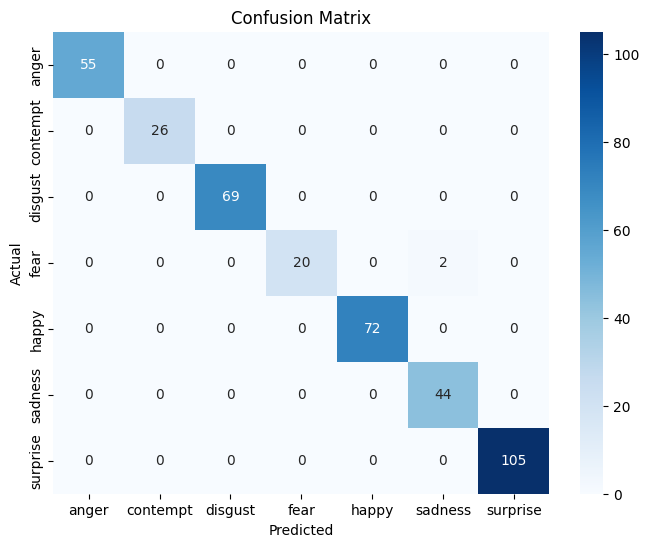

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test_integer, predictions)
print("Confusion Matrix:\n", confusion_mat)

# Calculate classification report
class_report = classification_report(y_test_integer, predictions, target_names=classes)
print("Classification Report:\n", class_report)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test_integer, predictions)
print("Overall Accuracy:", overall_accuracy)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

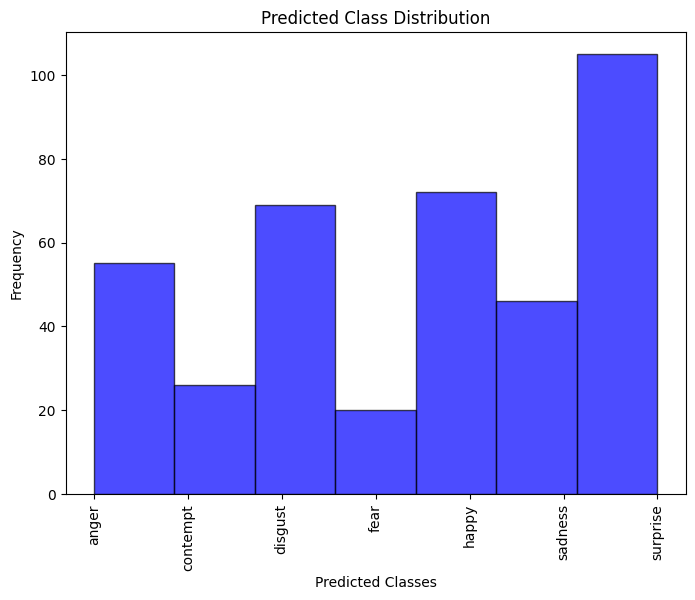

In [7]:
# Create a histogram of predicted classes
plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=len(classes), alpha=0.7, color='blue', edgecolor='black')
plt.xticks(range(len(classes)), classes, rotation='vertical')
plt.xlabel("Predicted Classes")
plt.ylabel("Frequency")
plt.title("Predicted Class Distribution")
plt.show()

Classification Report:
 {'anger': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 55}, 'contempt': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 26}, 'disgust': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 69}, 'fear': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1-score': 0.9523809523809523, 'support': 22}, 'happy': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 72}, 'sadness': {'precision': 0.9565217391304348, 'recall': 1.0, 'f1-score': 0.9777777777777777, 'support': 44}, 'surprise': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 105}, 'accuracy': 0.9949109414758269, 'macro avg': {'precision': 0.9937888198757764, 'recall': 0.987012987012987, 'f1-score': 0.9900226757369615, 'support': 393}, 'weighted avg': {'precision': 0.9951322048899215, 'recall': 0.9949109414758269, 'f1-score': 0.9948463185104407, 'support': 393}}


<Figure size 1000x600 with 0 Axes>

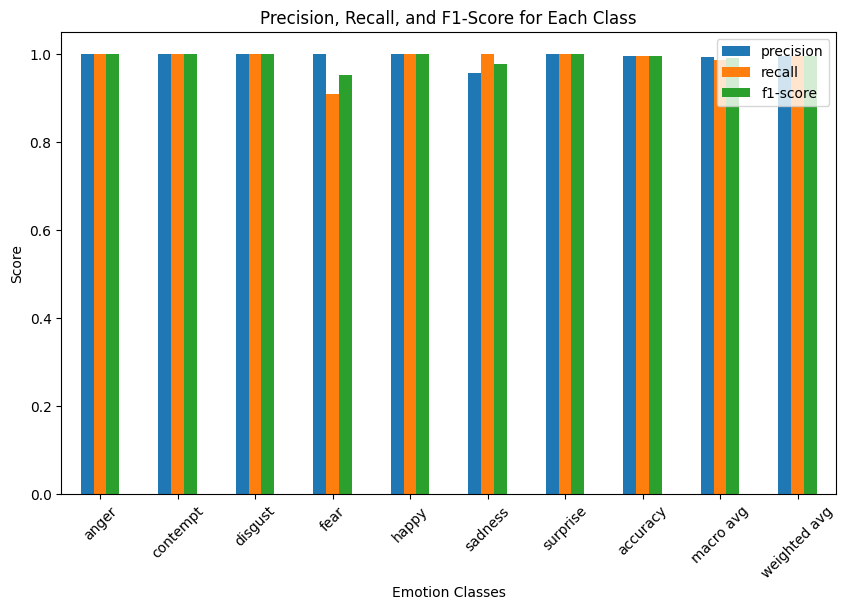

In [8]:
# Calculate classification report
class_report = classification_report(y_test_integer, predictions, target_names=classes, output_dict=True)
print("Classification Report:\n", class_report)

# Convert classification report dictionary to a DataFrame for easier manipulation
import pandas as pd
report_df = pd.DataFrame(class_report).transpose()

# Visualize precision, recall, F1-score for each class
plt.figure(figsize=(10, 6))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Emotion Classes')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()



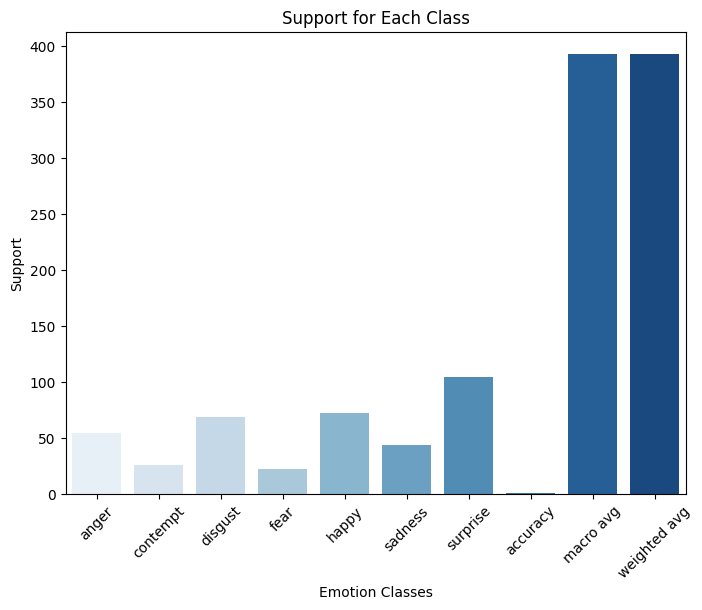

In [9]:
# Visualize support for each class
plt.figure(figsize=(8, 6))
sns.barplot(x=report_df.index, y=report_df['support'], palette='Blues')
plt.title('Support for Each Class')
plt.xlabel('Emotion Classes')
plt.ylabel('Support')
plt.xticks(rotation=45)
plt.show()

In [10]:
image_path_to_predict = '/content/extracted/anger/S010_004_00000018.png'  # Replace with the path to your image
img_to_predict = tf.keras.preprocessing.image.load_img(image_path_to_predict, target_size=(48, 48))
img_array_to_predict = tf.keras.preprocessing.image.img_to_array(img_to_predict)

# Use your CNN model to extract features from the image
features_to_predict = model.predict(np.expand_dims(img_array_to_predict, axis=0))

# Flatten the extracted features
features_to_predict_flatten = features_to_predict.reshape(1, -1)

# Use the SVM classifier to predict the emotion class
predicted_class_index = svm_classifier.predict(features_to_predict_flatten)[0]
predicted_class = classes[predicted_class_index]

print("Predicted Emotion:", predicted_class)


1/1 [==============================] - 0s 48ms/step
Predicted Emotion: anger


1/1 [==============================] - 0s 112ms/step


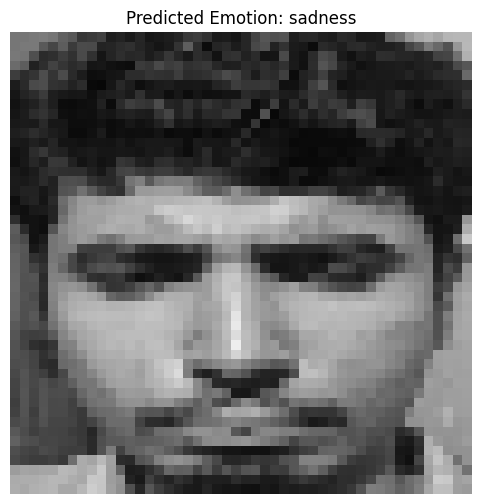

In [11]:
import matplotlib.pyplot as plt

# Load and preprocess the image you want to predict
image_path_to_predict = '/content/output-onlinetools.png'  # Replace with the path to your image
img_to_predict = tf.keras.preprocessing.image.load_img(image_path_to_predict, target_size=(48, 48))
img_array_to_predict = tf.keras.preprocessing.image.img_to_array(img_to_predict)

# Use your CNN model to extract features from the image
features_to_predict = model.predict(np.expand_dims(img_array_to_predict, axis=0))

# Flatten the extracted features
features_to_predict_flatten = features_to_predict.reshape(1, -1)

# Use the SVM classifier to predict the emotion class
predicted_class_index = svm_classifier.predict(features_to_predict_flatten)[0]
predicted_class = classes[predicted_class_index]

# Display the image with the predicted emotion
plt.figure(figsize=(6, 6))
plt.imshow(img_to_predict)
plt.title(f"Predicted Emotion: {predicted_class}")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 88ms/step


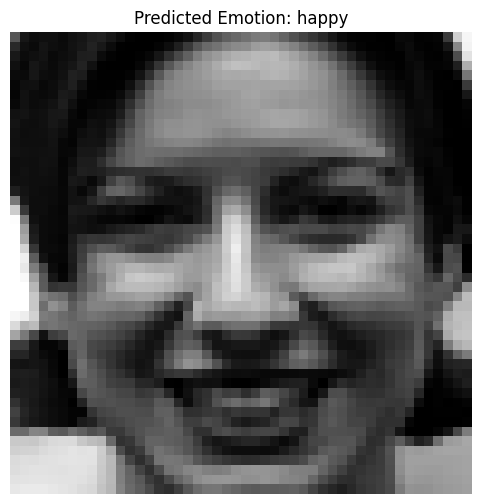

1/1 [==============================] - 0s 74ms/step


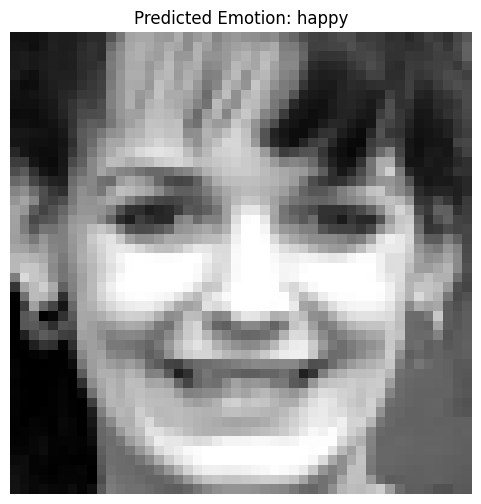

1/1 [==============================] - 0s 55ms/step


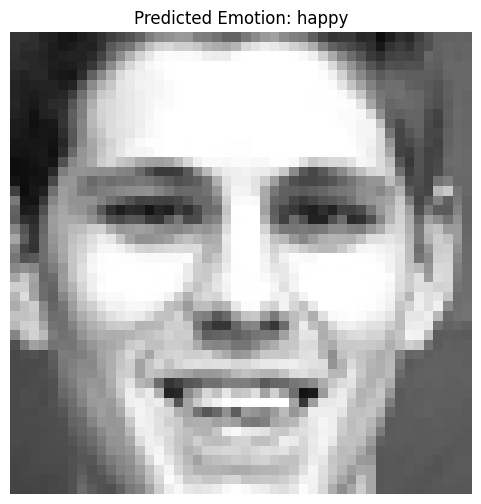

1/1 [==============================] - 0s 40ms/step


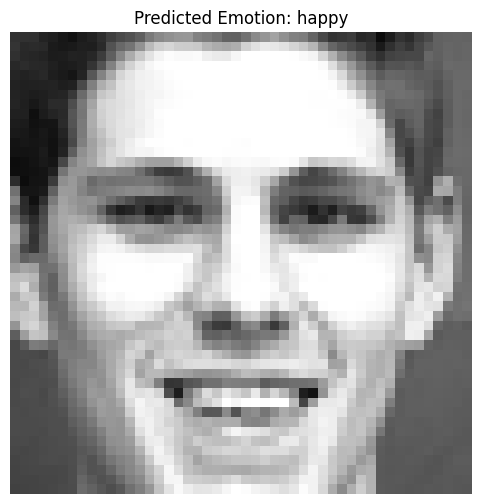

1/1 [==============================] - 0s 39ms/step


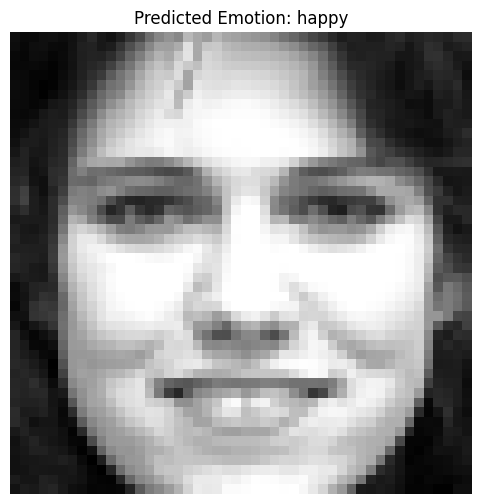

1/1 [==============================] - 0s 39ms/step


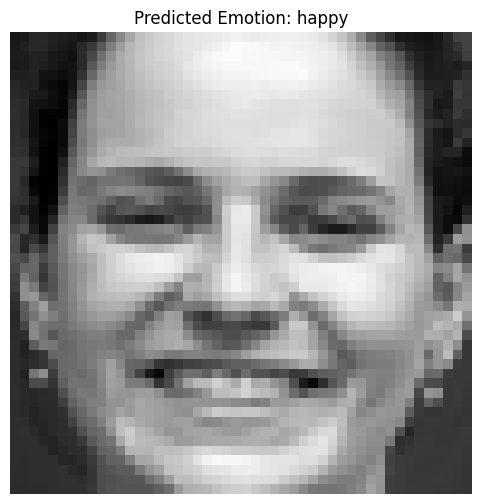

1/1 [==============================] - 0s 31ms/step


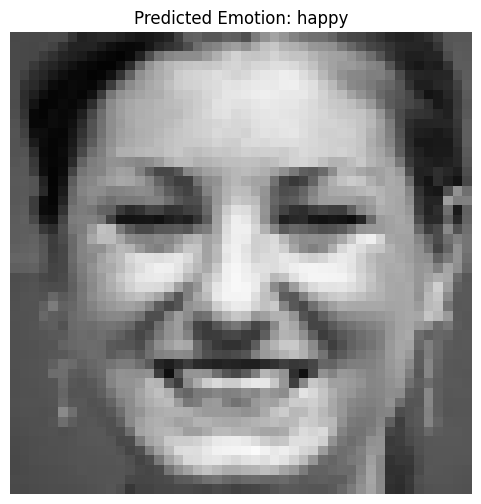

1/1 [==============================] - 0s 36ms/step


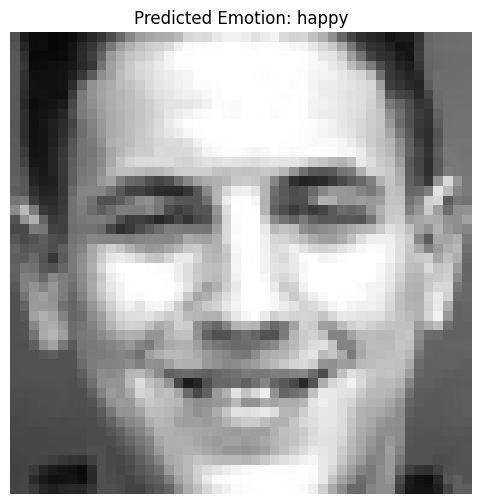

1/1 [==============================] - 0s 20ms/step


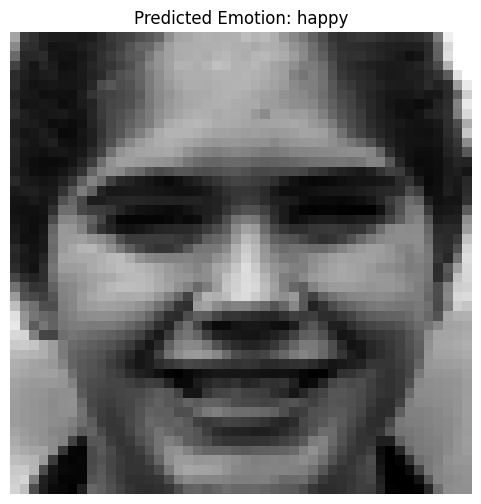

1/1 [==============================] - 0s 20ms/step


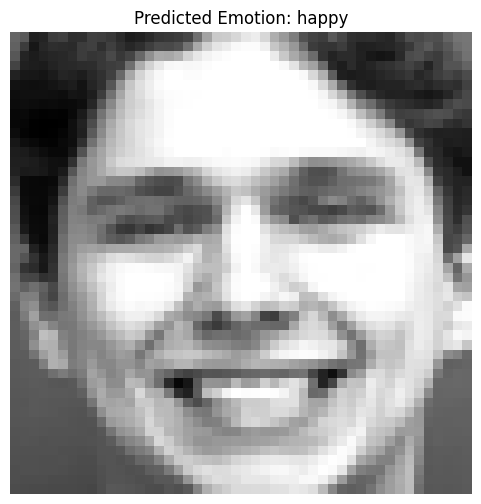

1/1 [==============================] - 0s 20ms/step


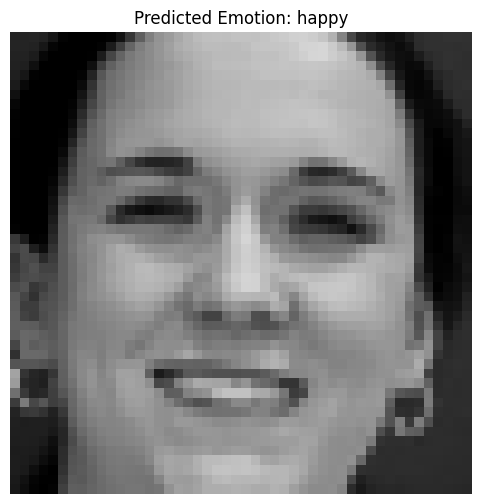

1/1 [==============================] - 0s 20ms/step


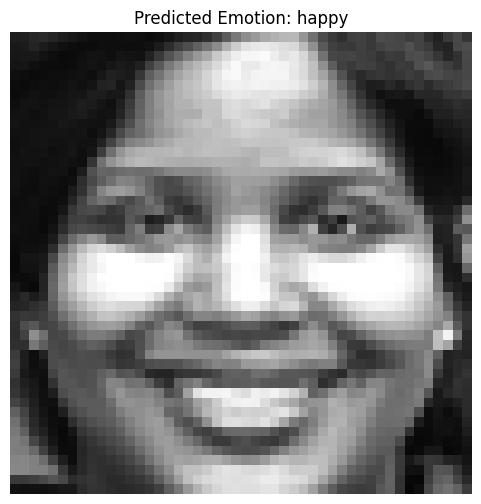

1/1 [==============================] - 0s 24ms/step


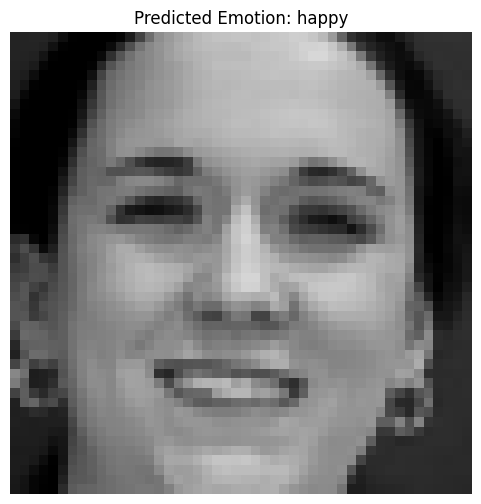

1/1 [==============================] - 0s 21ms/step


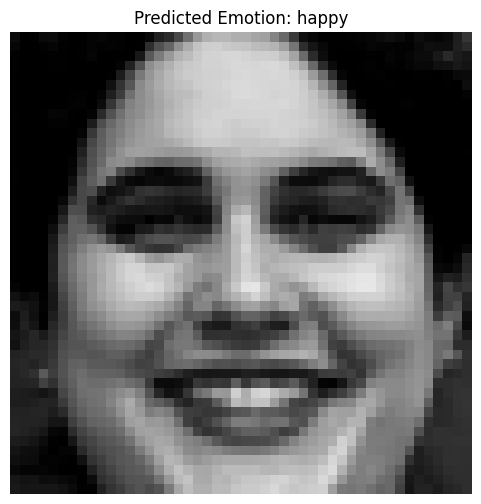

1/1 [==============================] - 0s 20ms/step


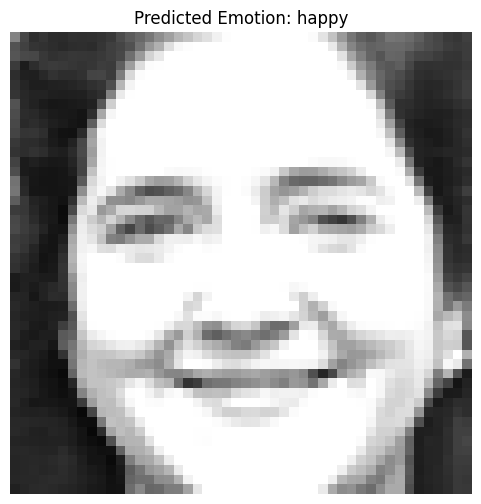

1/1 [==============================] - 0s 20ms/step


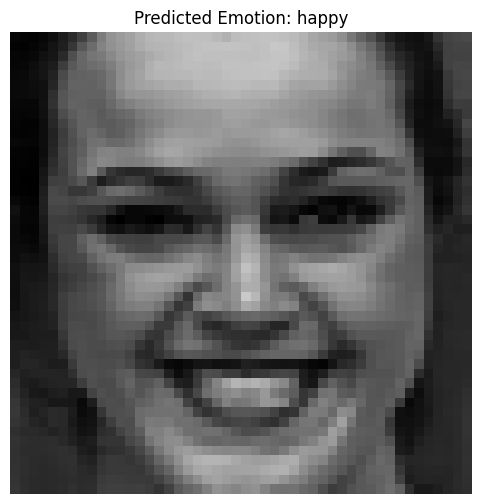

1/1 [==============================] - 0s 20ms/step


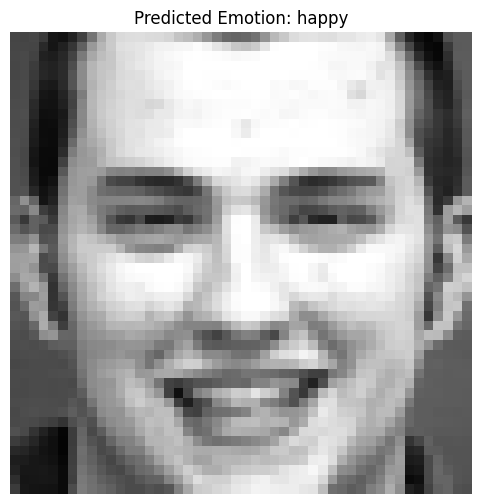

1/1 [==============================] - 0s 23ms/step


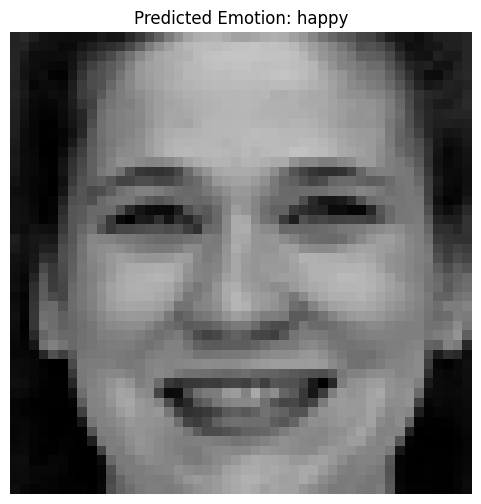

1/1 [==============================] - 0s 22ms/step


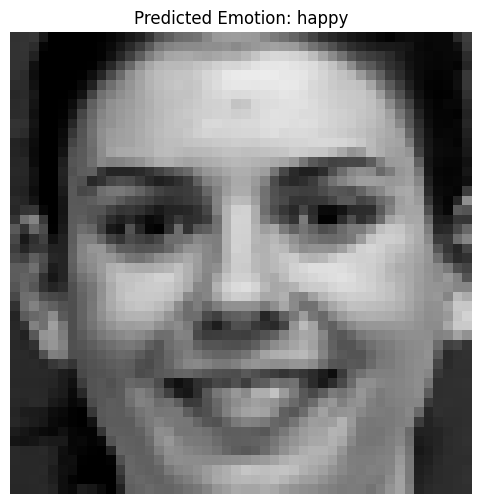

1/1 [==============================] - 0s 20ms/step


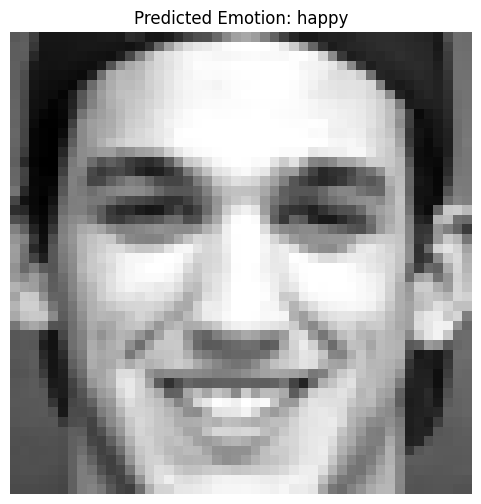

1/1 [==============================] - 0s 21ms/step


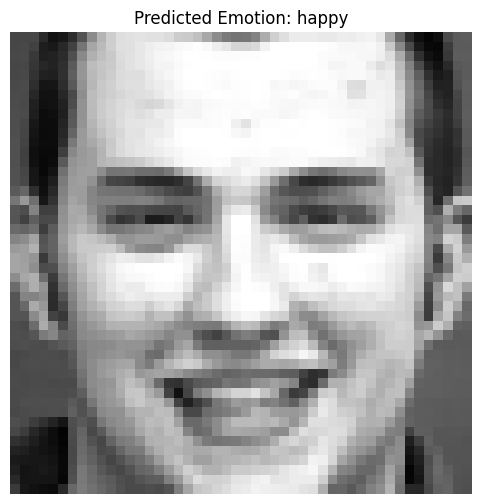

1/1 [==============================] - 0s 21ms/step


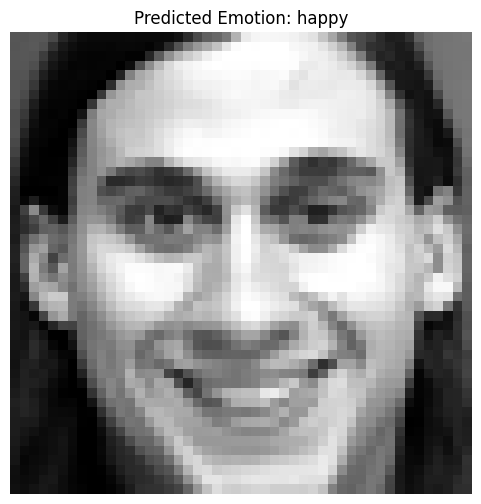

1/1 [==============================] - 0s 21ms/step


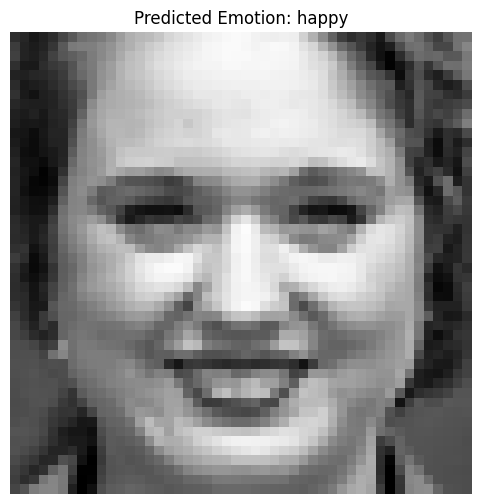

1/1 [==============================] - 0s 21ms/step


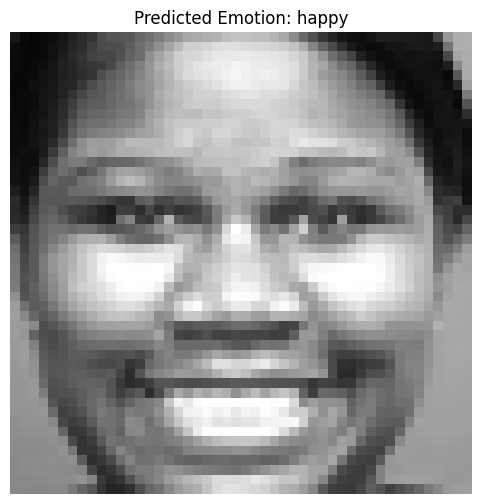

1/1 [==============================] - 0s 20ms/step


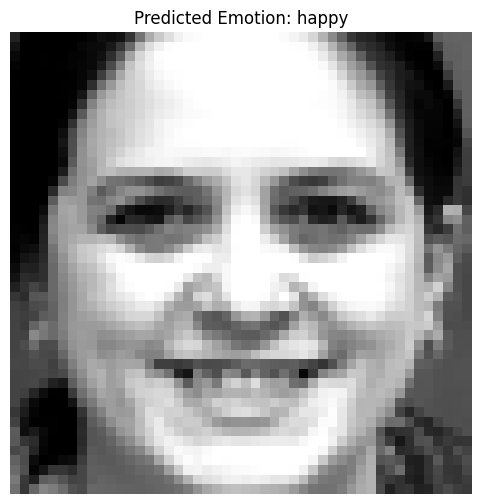

1/1 [==============================] - 0s 19ms/step


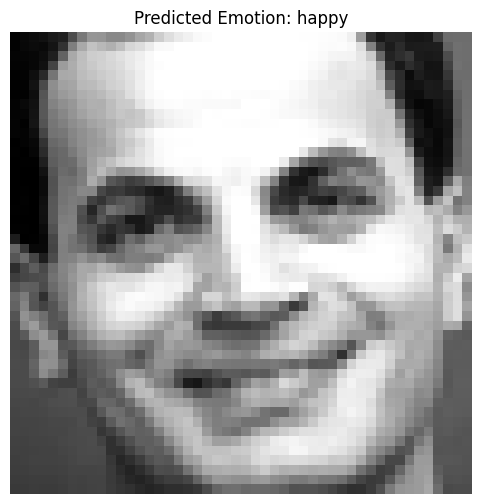

1/1 [==============================] - 0s 21ms/step


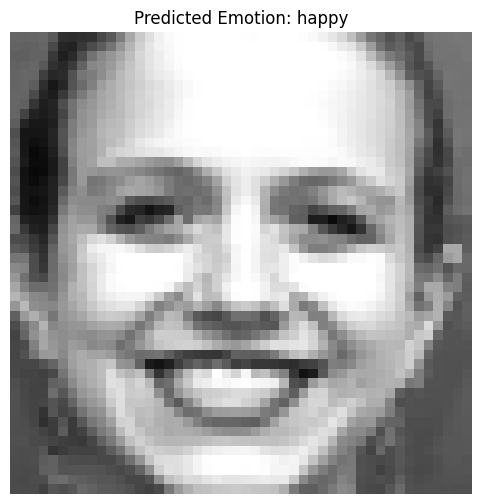

1/1 [==============================] - 0s 24ms/step


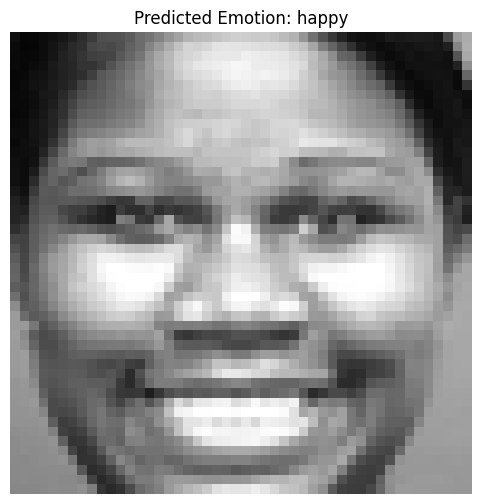

1/1 [==============================] - 0s 27ms/step


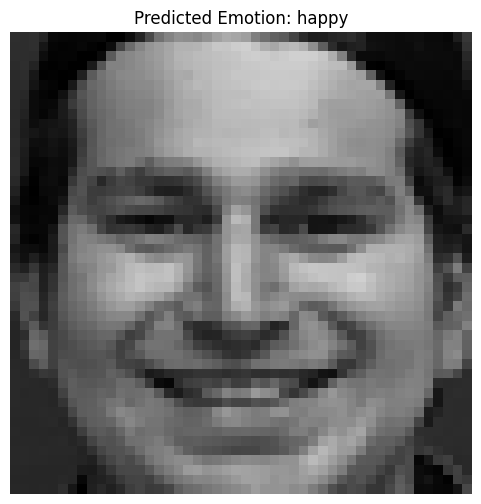

1/1 [==============================] - 0s 24ms/step


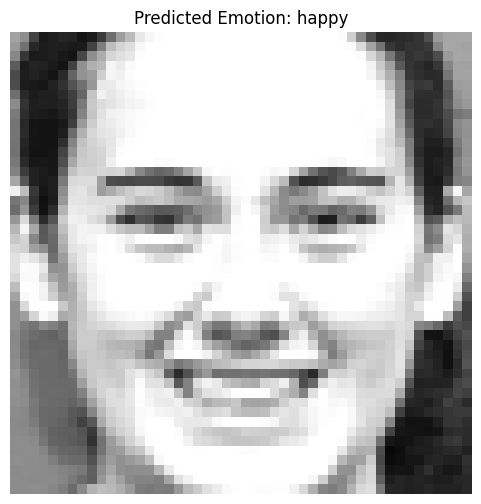

1/1 [==============================] - 0s 22ms/step


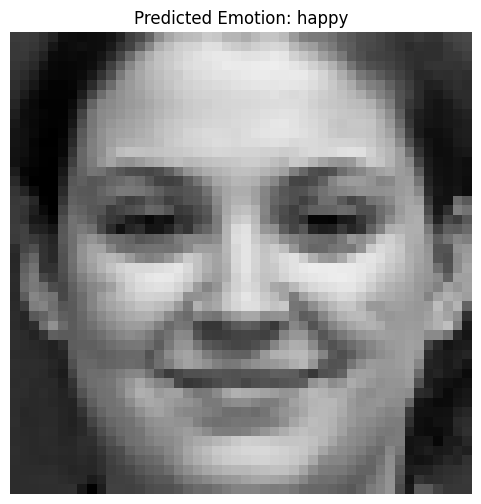

1/1 [==============================] - 0s 23ms/step


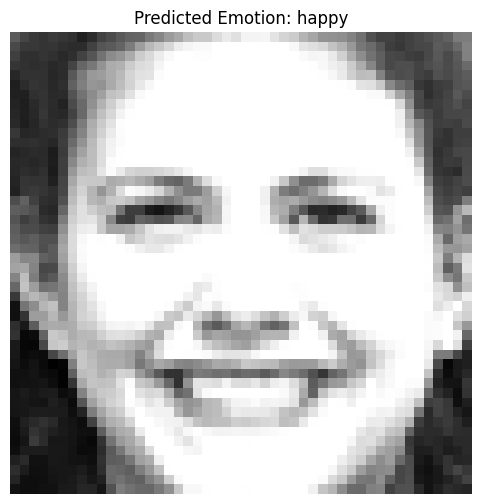

1/1 [==============================] - 0s 22ms/step


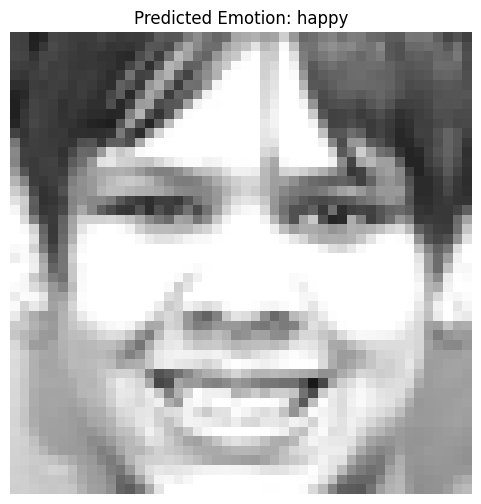

1/1 [==============================] - 0s 20ms/step


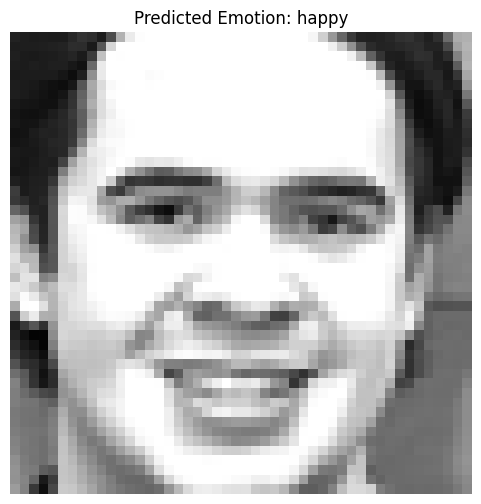

1/1 [==============================] - 0s 22ms/step


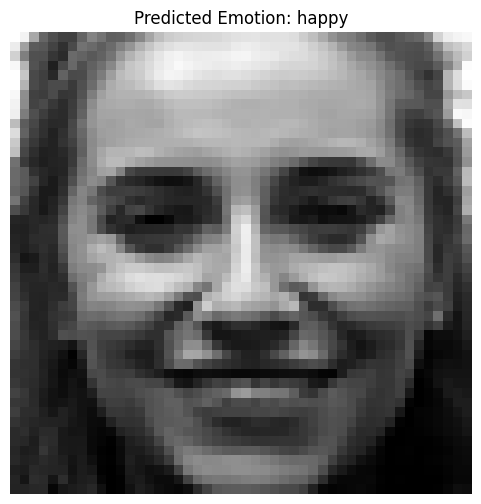

1/1 [==============================] - 0s 20ms/step


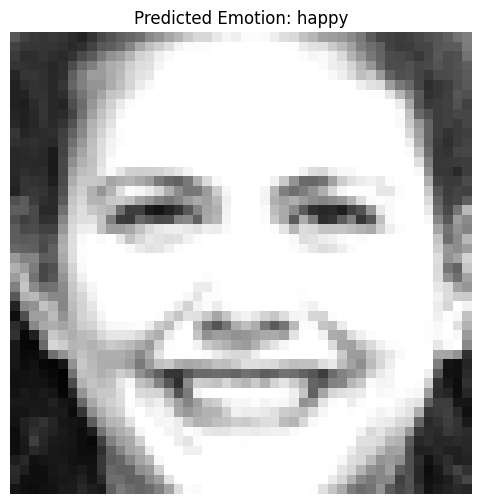

1/1 [==============================] - 0s 21ms/step


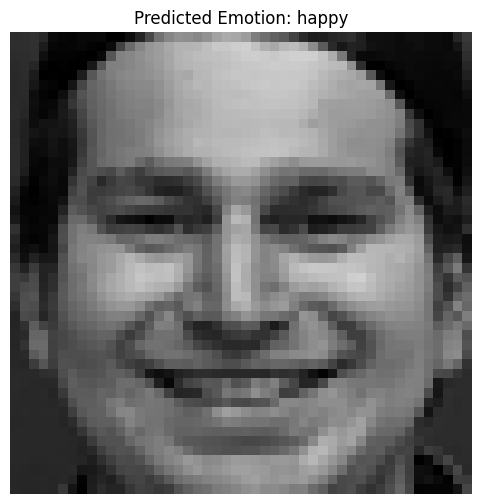

1/1 [==============================] - 0s 23ms/step


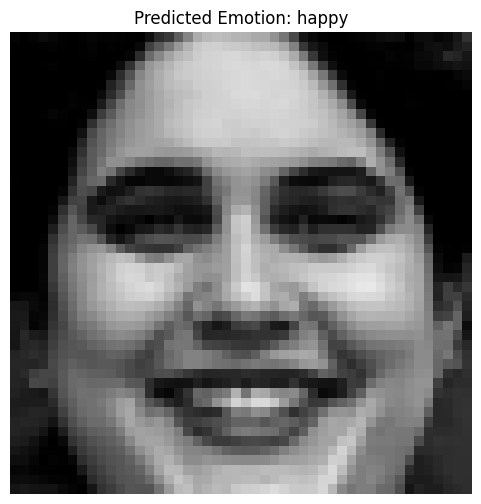

1/1 [==============================] - 0s 22ms/step


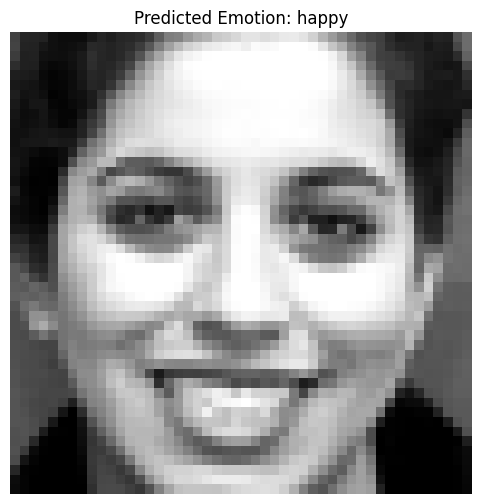

1/1 [==============================] - 0s 22ms/step


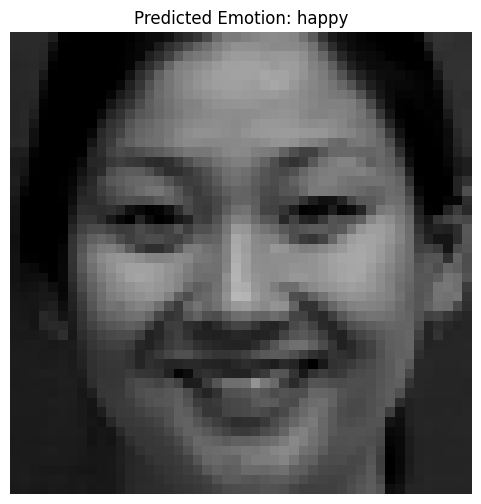

1/1 [==============================] - 0s 22ms/step


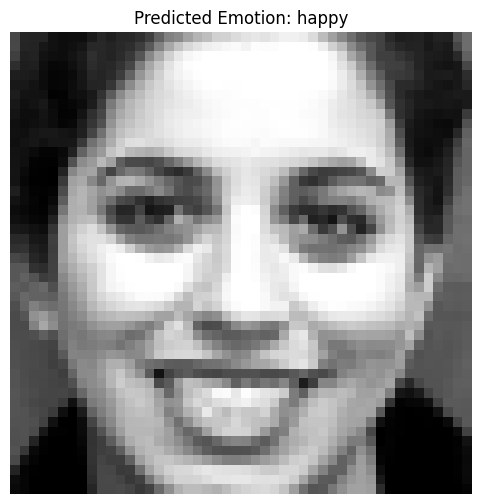

1/1 [==============================] - 0s 21ms/step


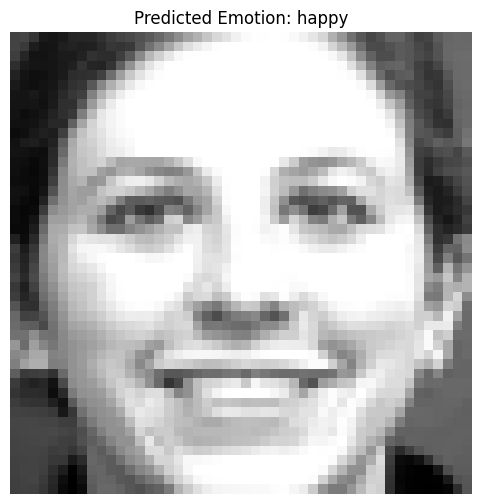

1/1 [==============================] - 0s 21ms/step


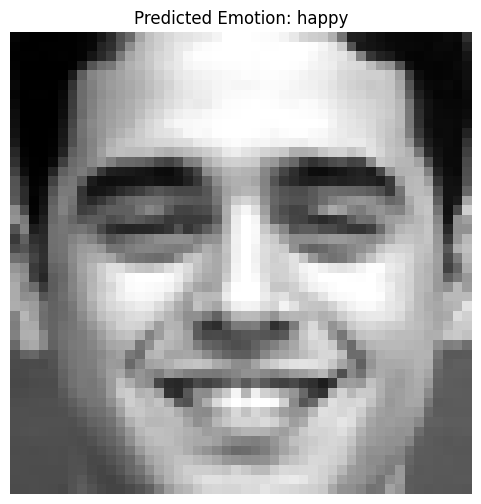

1/1 [==============================] - 0s 21ms/step


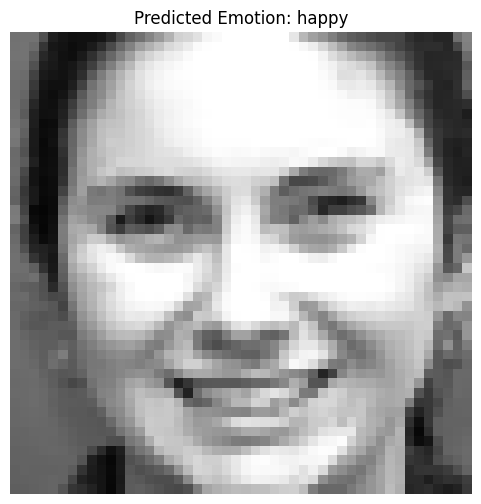

1/1 [==============================] - 0s 21ms/step


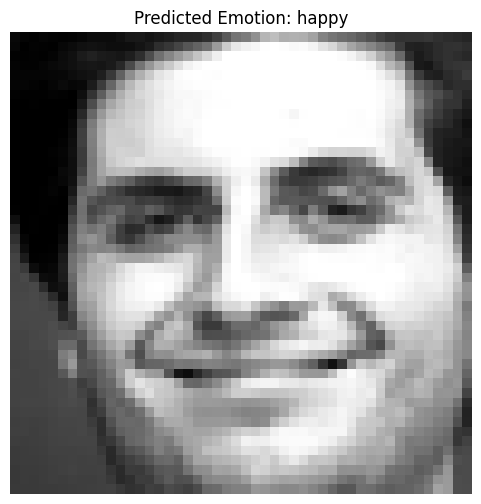

1/1 [==============================] - 0s 21ms/step


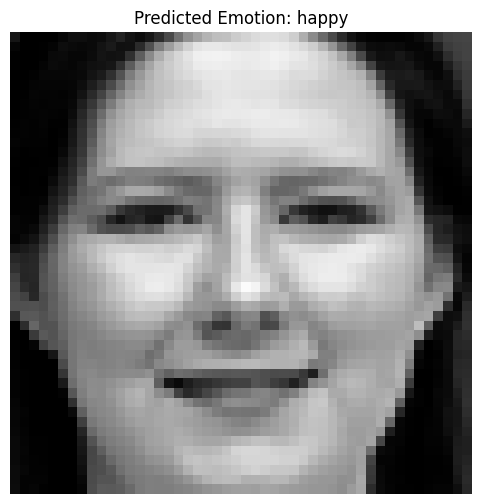

1/1 [==============================] - 0s 21ms/step


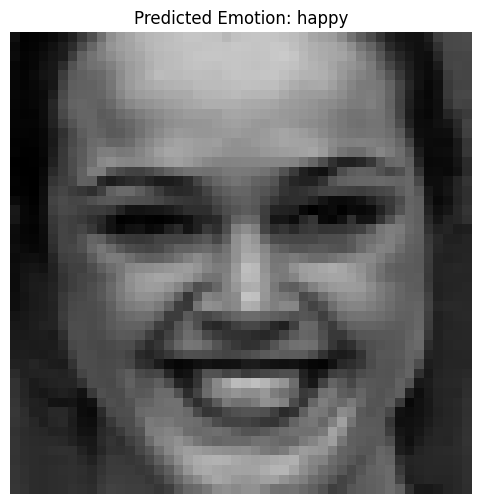

1/1 [==============================] - 0s 21ms/step


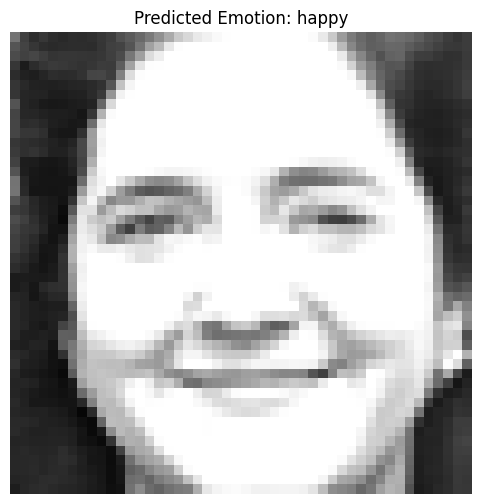

1/1 [==============================] - 0s 34ms/step


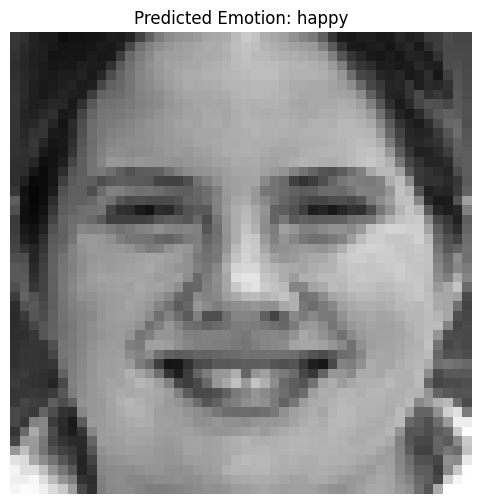

1/1 [==============================] - 0s 32ms/step


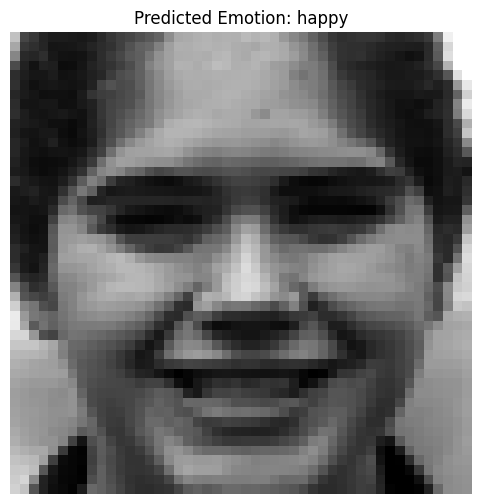

1/1 [==============================] - 0s 33ms/step


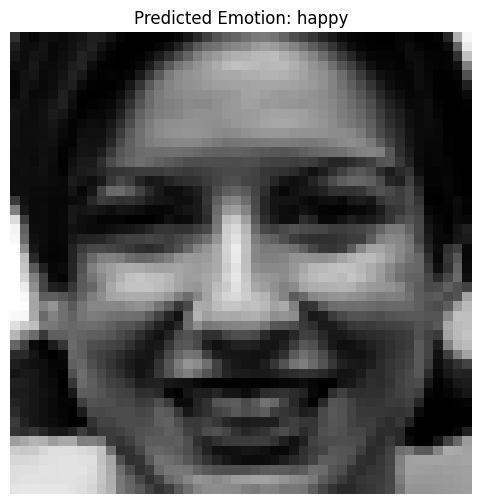

1/1 [==============================] - 0s 30ms/step


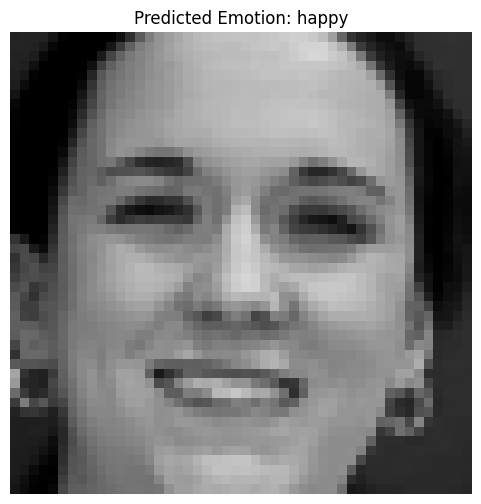

1/1 [==============================] - 0s 32ms/step


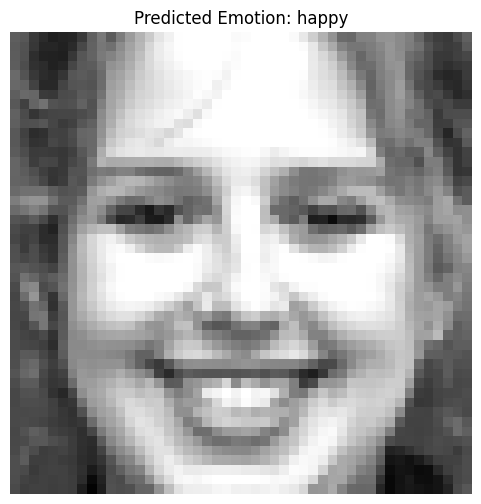

1/1 [==============================] - 0s 32ms/step


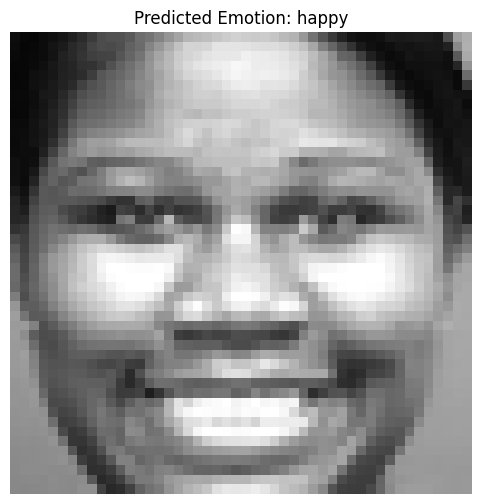

1/1 [==============================] - 0s 31ms/step


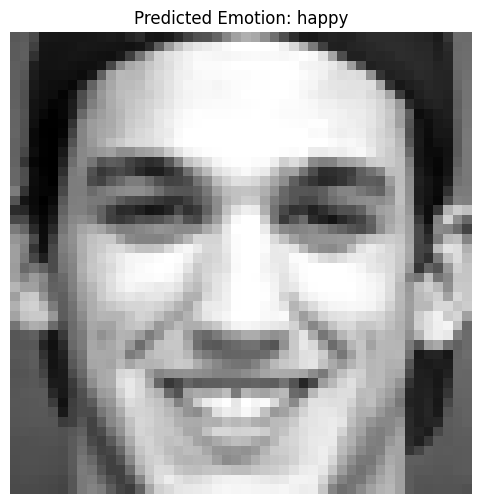

1/1 [==============================] - 0s 33ms/step


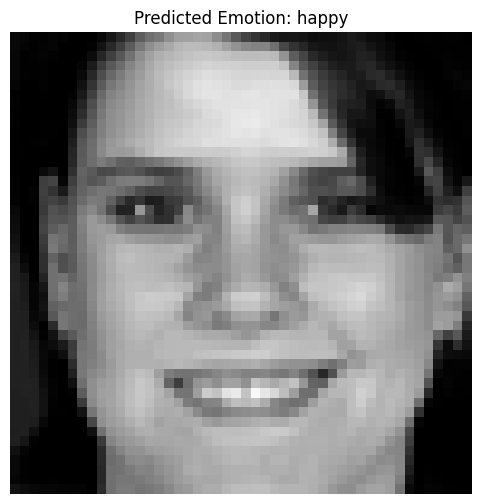

1/1 [==============================] - 0s 38ms/step


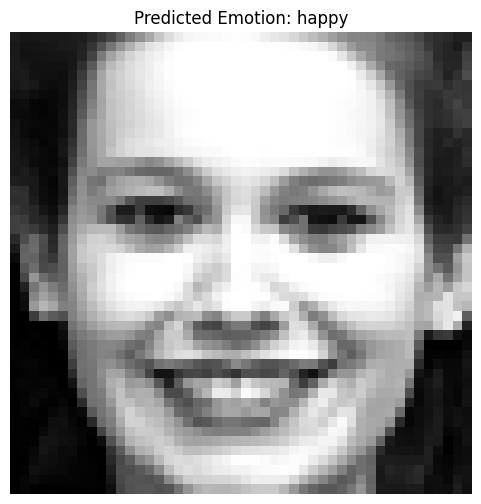

1/1 [==============================] - 0s 30ms/step


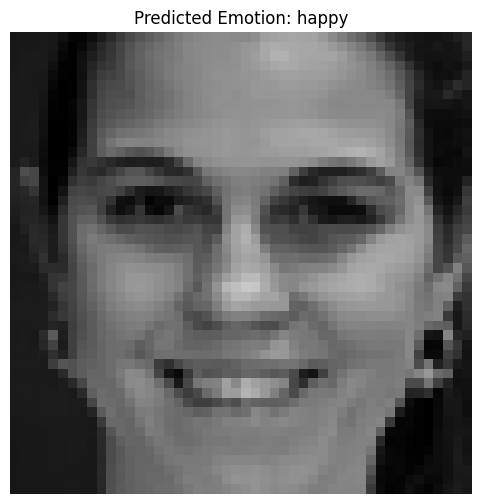

1/1 [==============================] - 0s 33ms/step


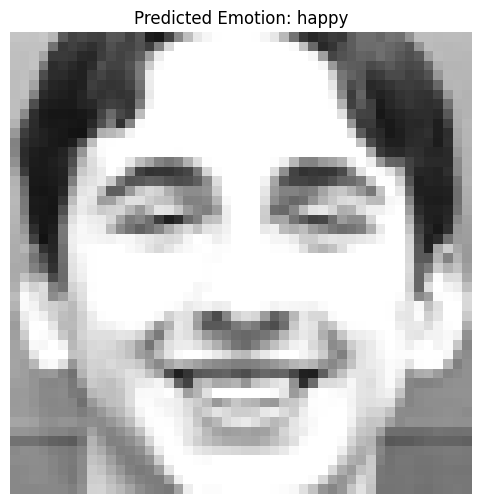

1/1 [==============================] - 0s 21ms/step


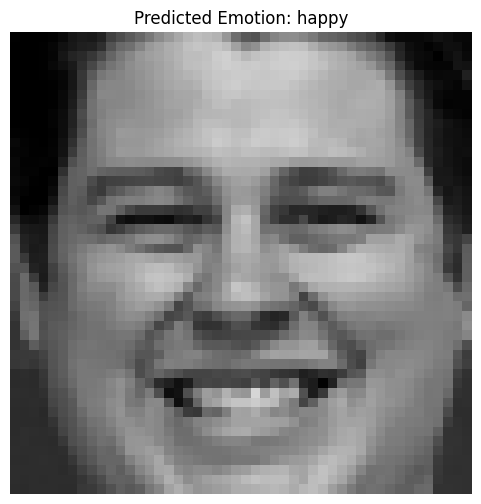

1/1 [==============================] - 0s 21ms/step


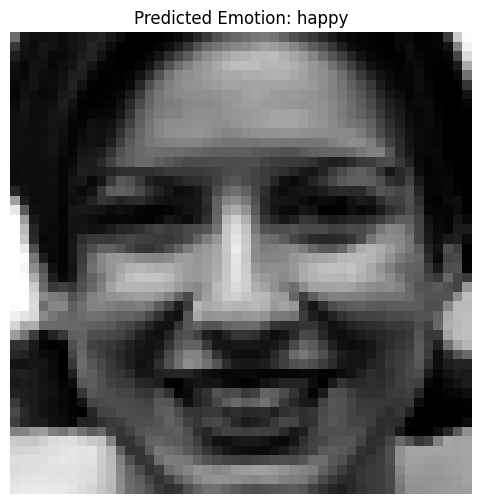

1/1 [==============================] - 0s 27ms/step


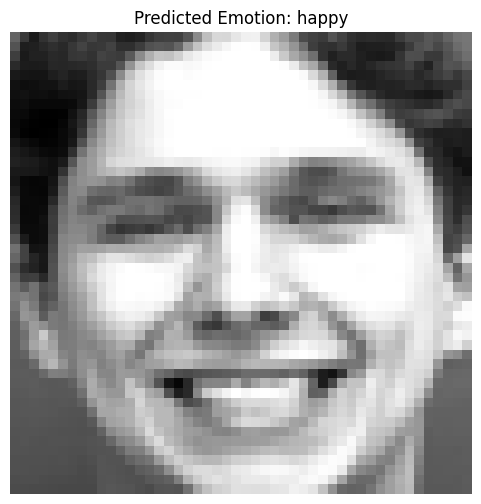

1/1 [==============================] - 0s 20ms/step


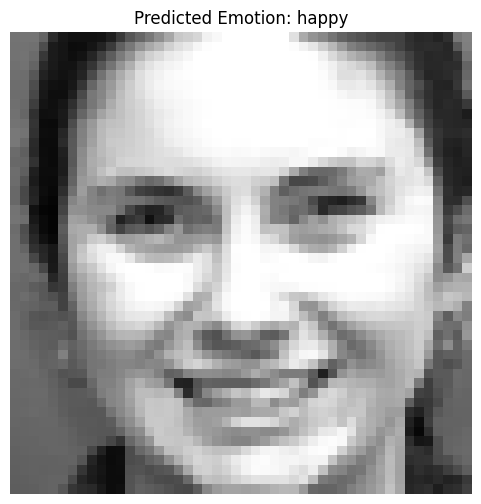

1/1 [==============================] - 0s 21ms/step


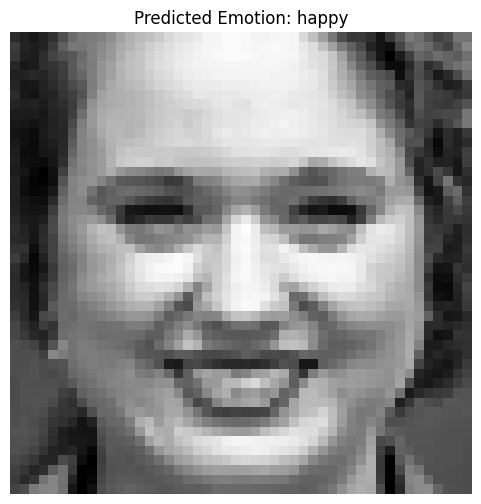

1/1 [==============================] - 0s 20ms/step


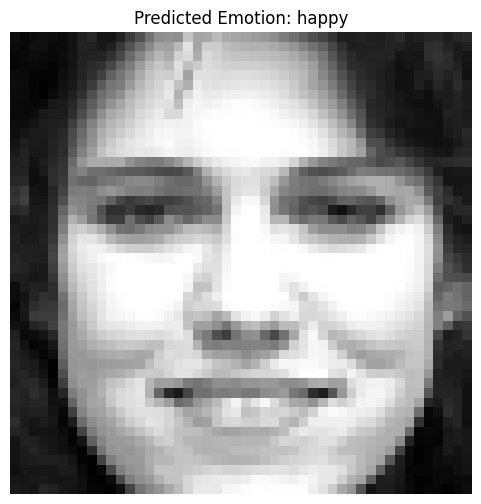

1/1 [==============================] - 0s 30ms/step


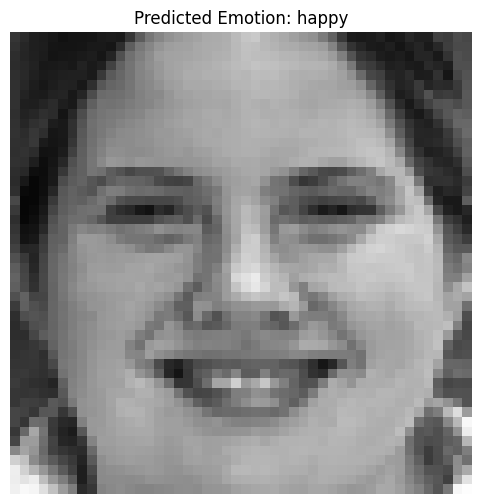

1/1 [==============================] - 0s 20ms/step


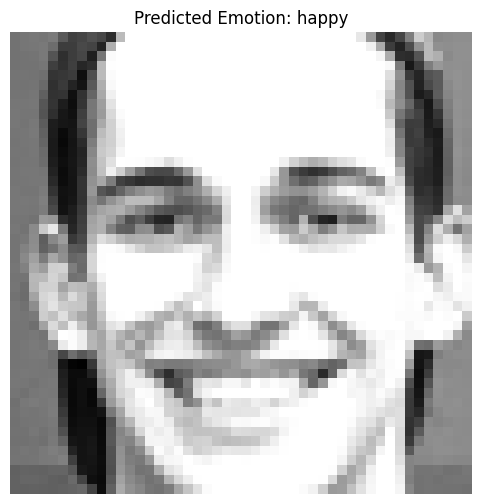

1/1 [==============================] - 0s 26ms/step


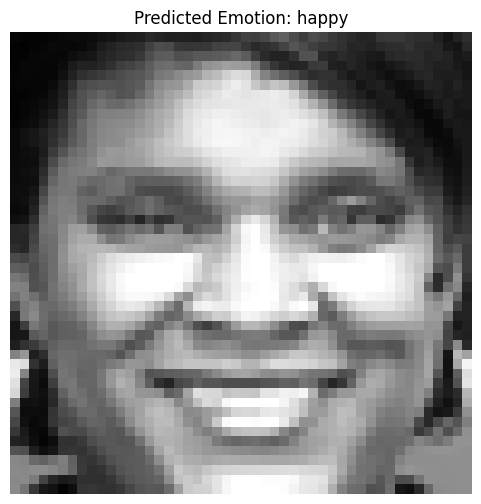

1/1 [==============================] - 0s 24ms/step


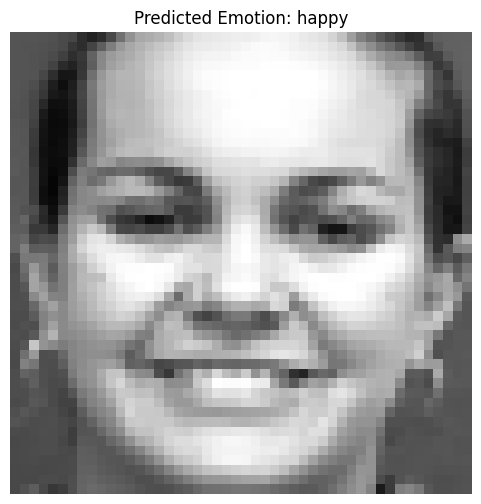

1/1 [==============================] - 0s 20ms/step


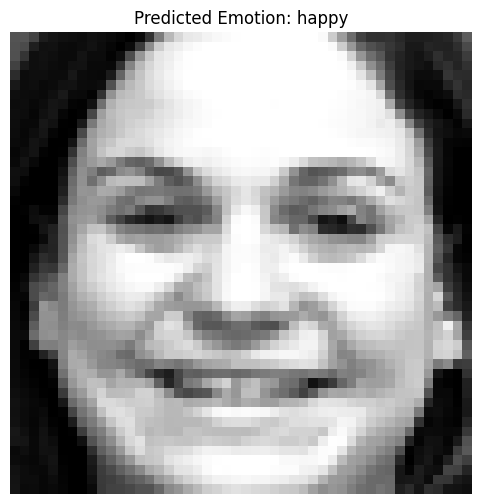

1/1 [==============================] - 0s 20ms/step


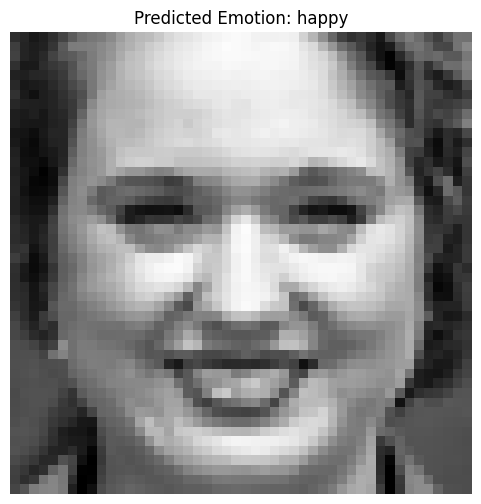

1/1 [==============================] - 0s 25ms/step


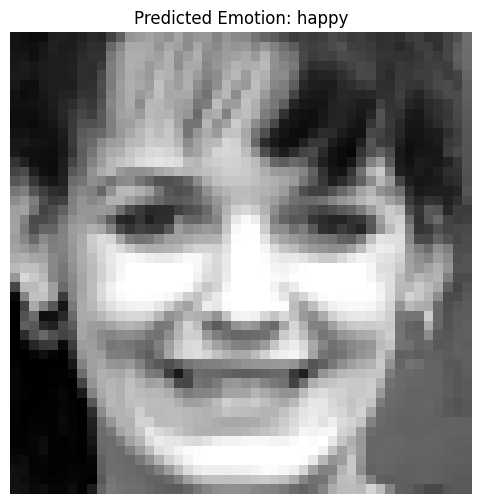

1/1 [==============================] - 0s 20ms/step


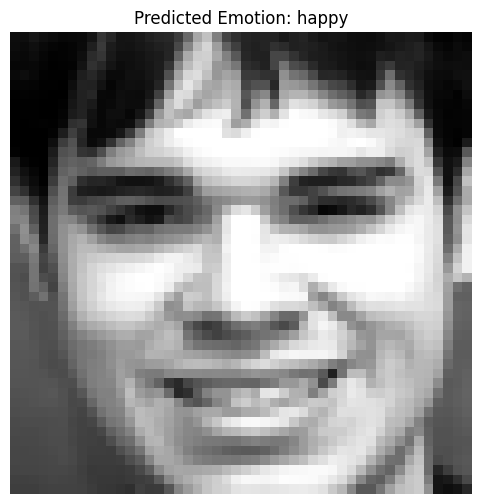

1/1 [==============================] - 0s 20ms/step


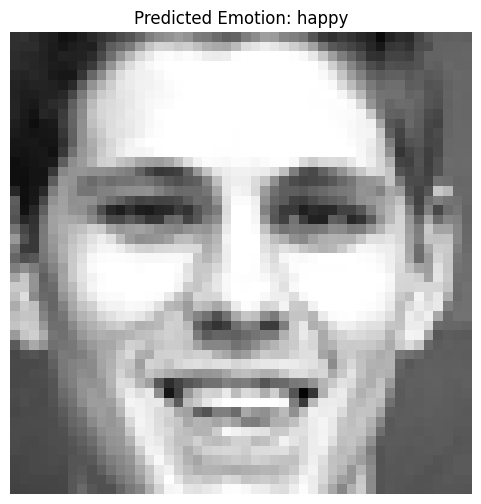

1/1 [==============================] - 0s 21ms/step


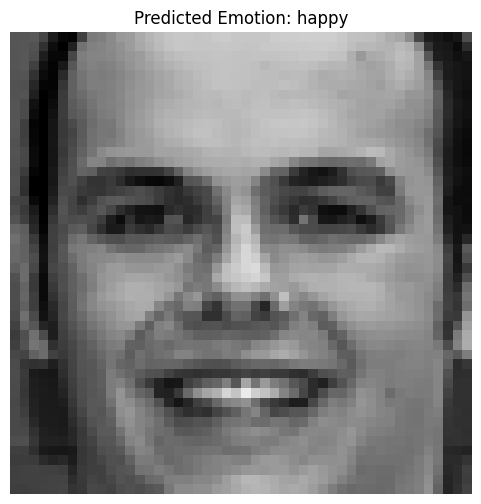

1/1 [==============================] - 0s 22ms/step


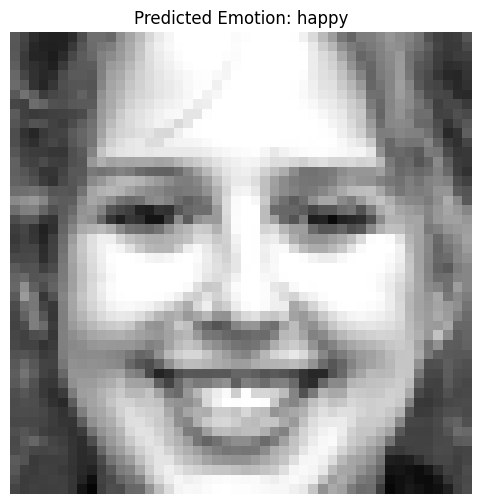

1/1 [==============================] - 0s 21ms/step


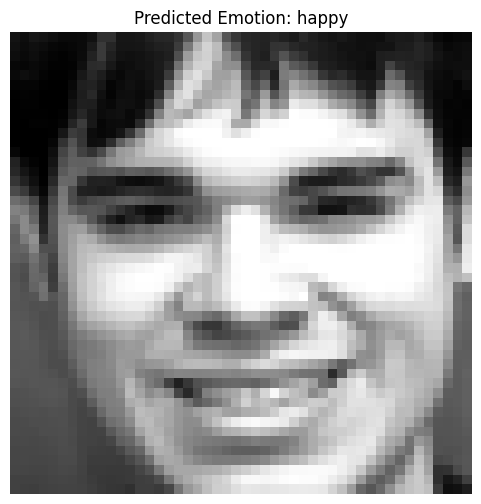

1/1 [==============================] - 0s 20ms/step


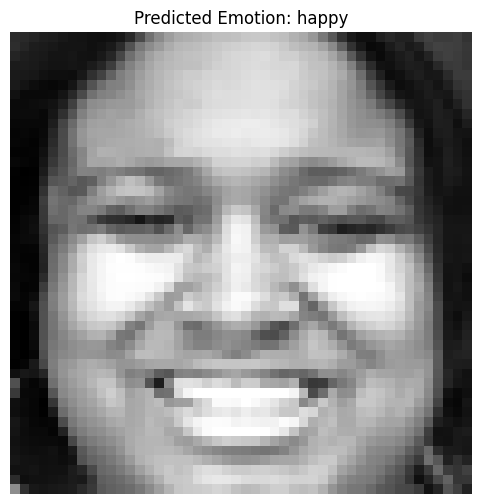

1/1 [==============================] - 0s 22ms/step


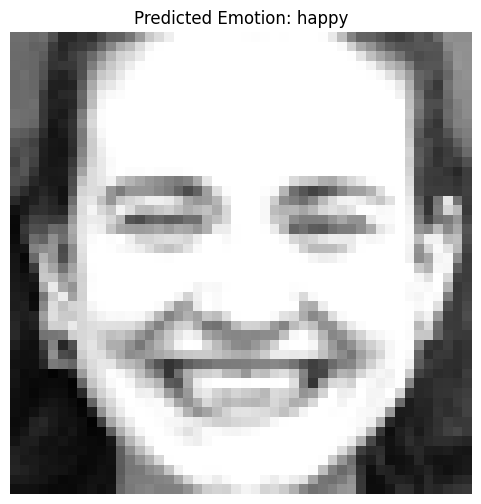

1/1 [==============================] - 0s 30ms/step


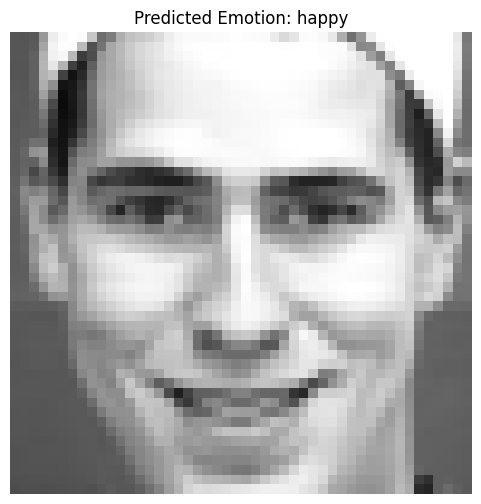

1/1 [==============================] - 0s 21ms/step


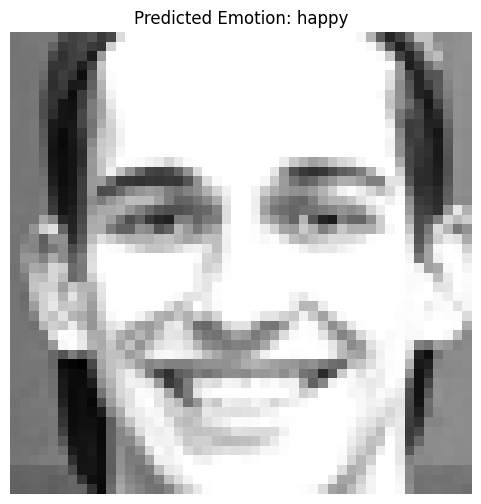

1/1 [==============================] - 0s 20ms/step


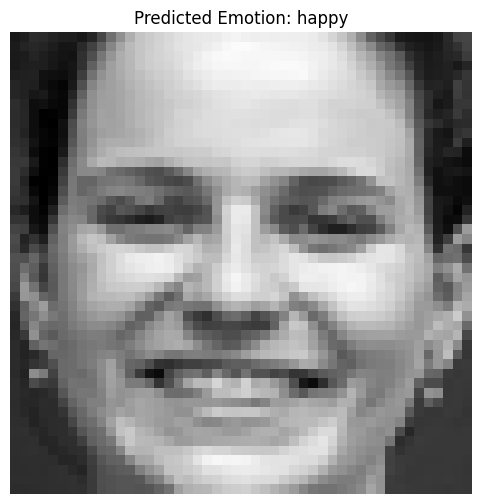

1/1 [==============================] - 0s 23ms/step


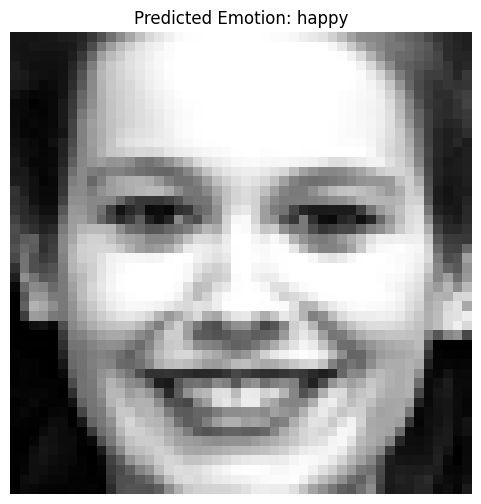

1/1 [==============================] - 0s 20ms/step


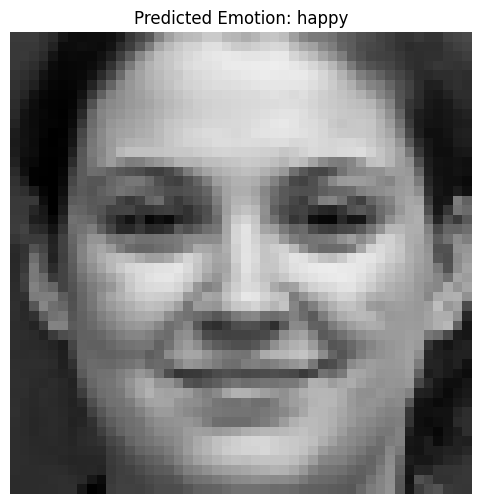

1/1 [==============================] - 0s 21ms/step


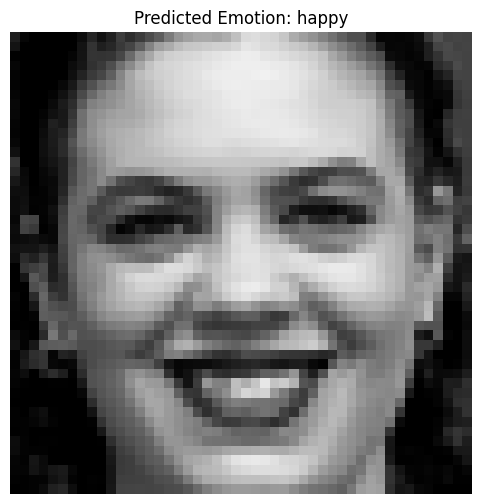

1/1 [==============================] - 0s 25ms/step


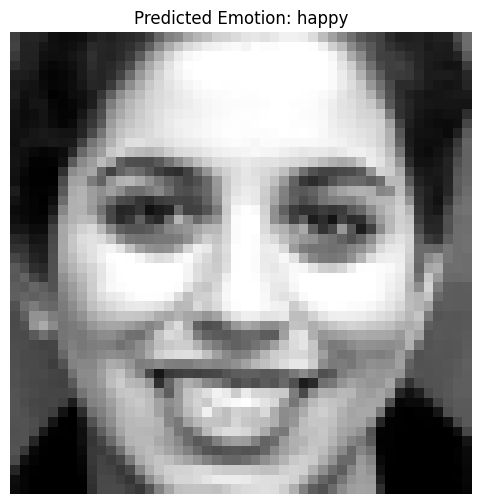

1/1 [==============================] - 0s 23ms/step


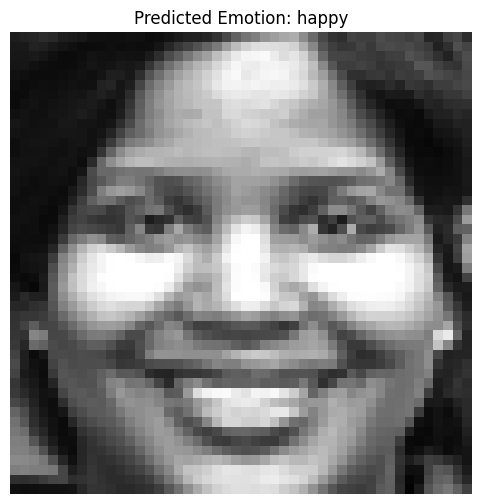

1/1 [==============================] - 0s 22ms/step


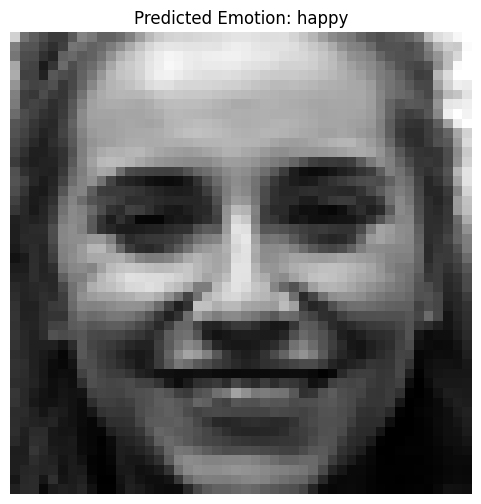

1/1 [==============================] - 0s 20ms/step


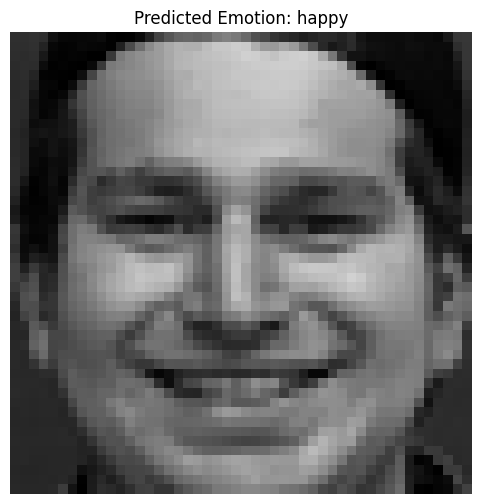

1/1 [==============================] - 0s 21ms/step


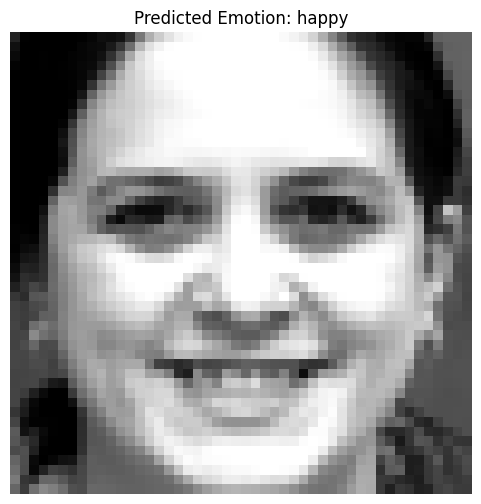

1/1 [==============================] - 0s 19ms/step


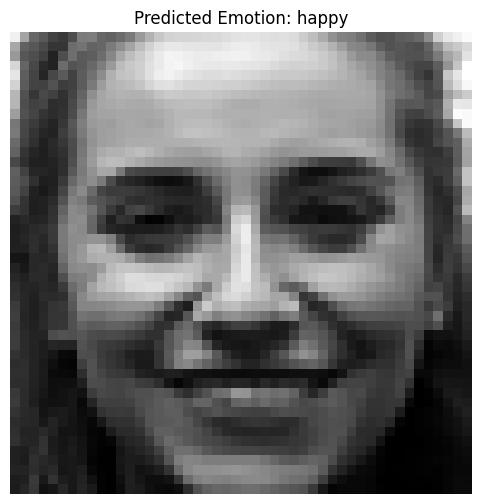

1/1 [==============================] - 0s 22ms/step


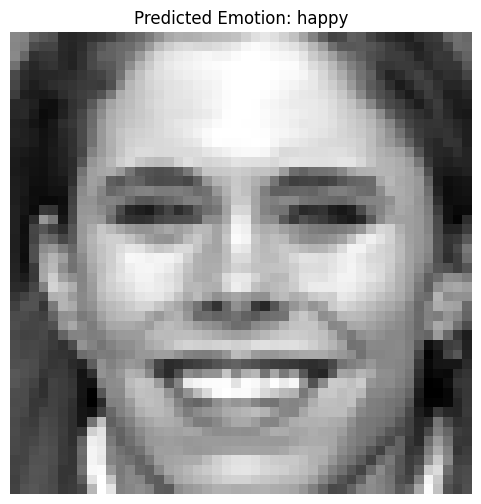

1/1 [==============================] - 0s 21ms/step


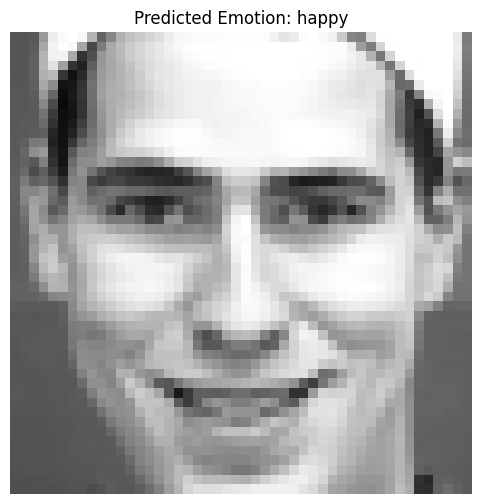

1/1 [==============================] - 0s 25ms/step


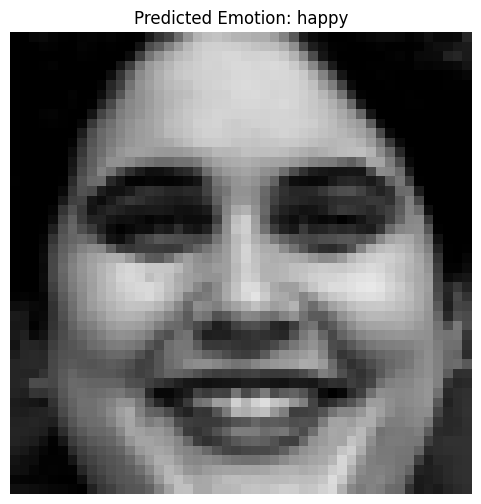

1/1 [==============================] - 0s 20ms/step


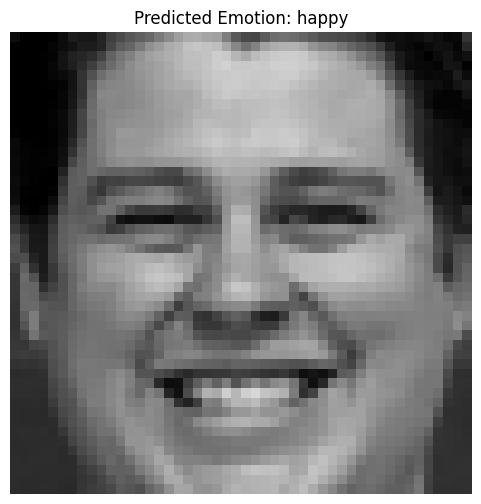

1/1 [==============================] - 0s 20ms/step


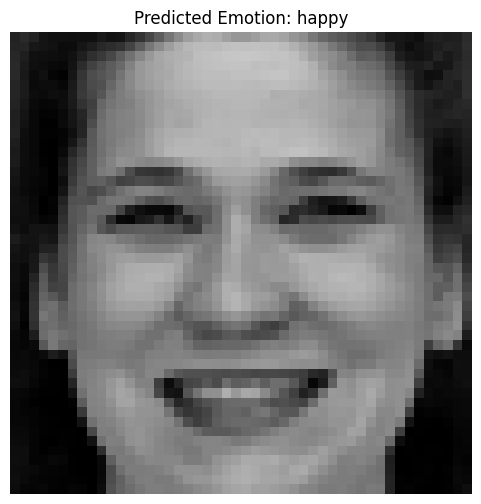

1/1 [==============================] - 0s 22ms/step


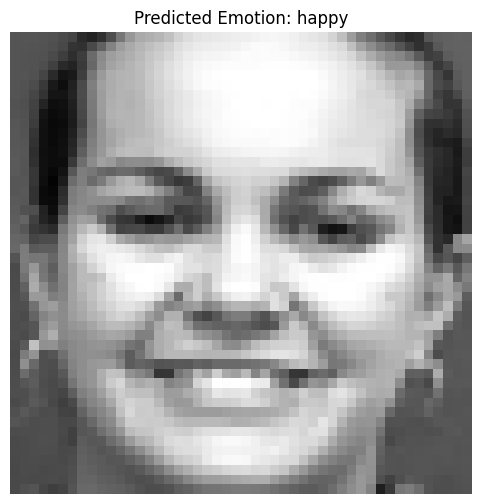

1/1 [==============================] - 0s 21ms/step


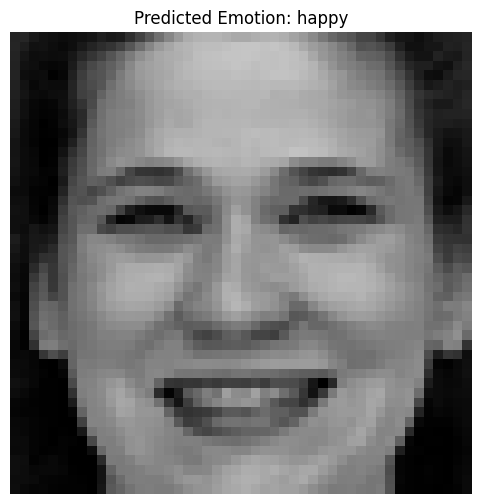

1/1 [==============================] - 0s 25ms/step


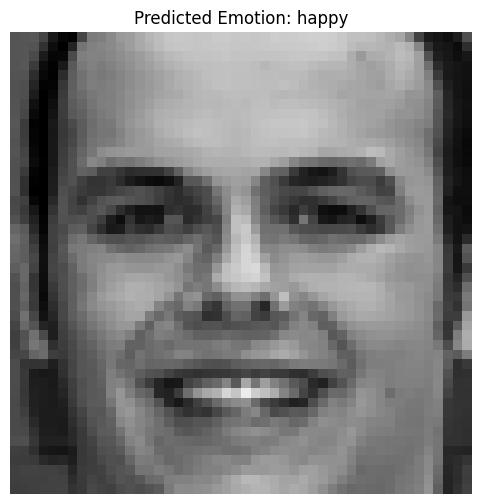

1/1 [==============================] - 0s 20ms/step


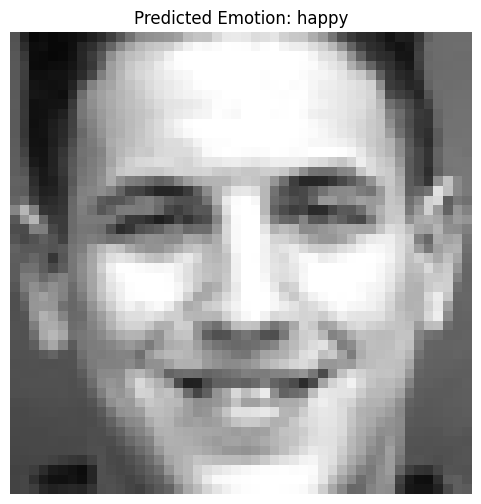

1/1 [==============================] - 0s 20ms/step


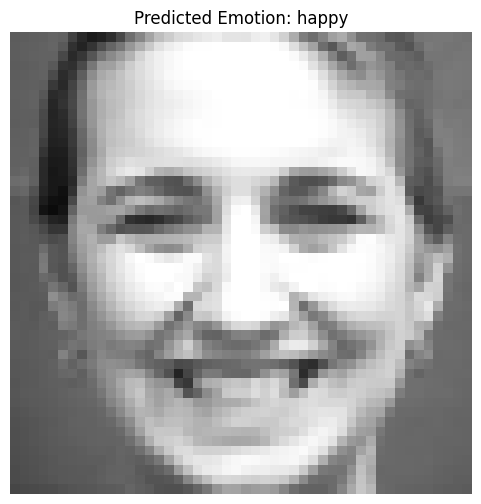

1/1 [==============================] - 0s 26ms/step


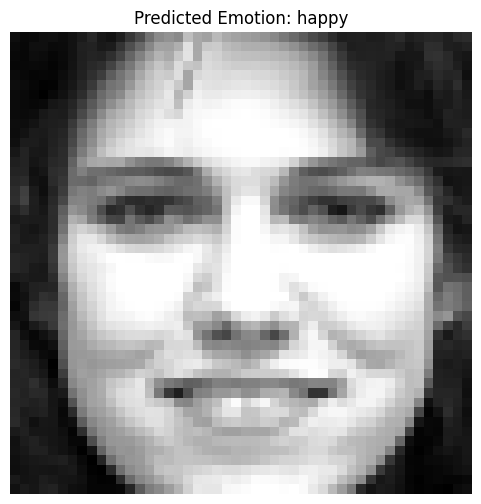

1/1 [==============================] - 0s 24ms/step


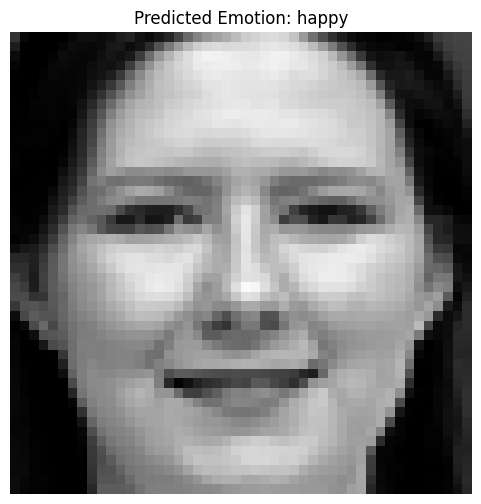

1/1 [==============================] - 0s 23ms/step


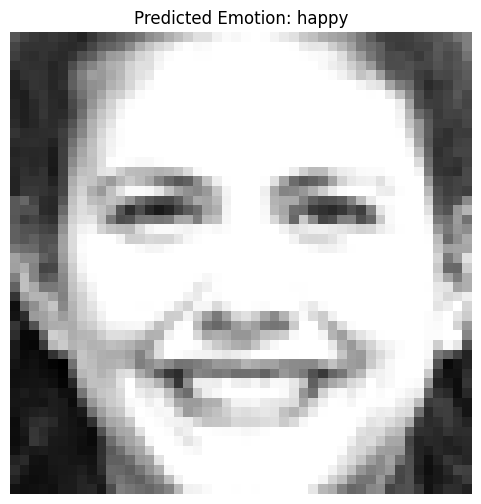

1/1 [==============================] - 0s 48ms/step


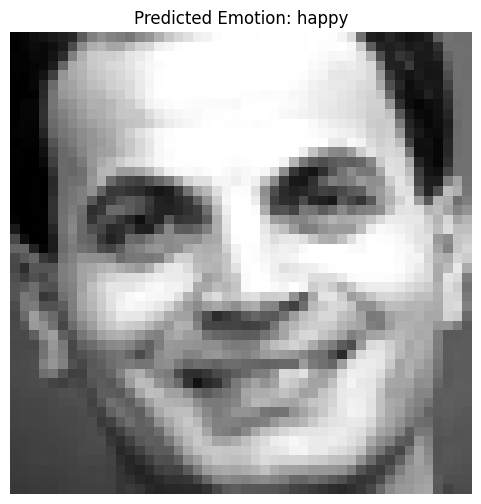

1/1 [==============================] - 0s 33ms/step


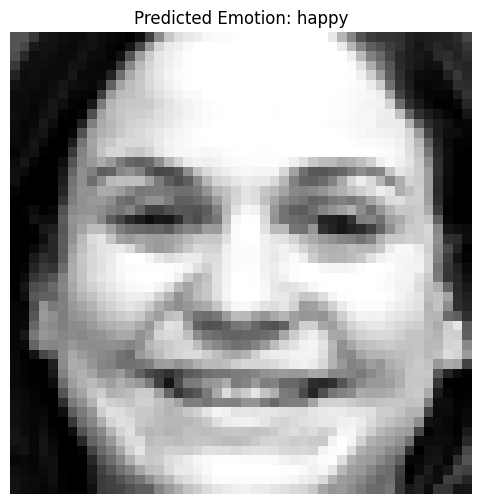

1/1 [==============================] - 0s 36ms/step


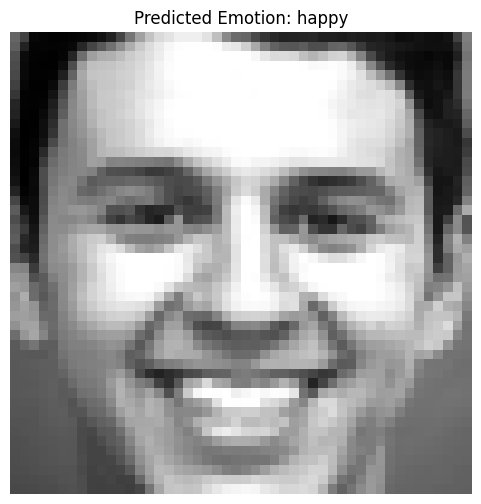

1/1 [==============================] - 0s 35ms/step


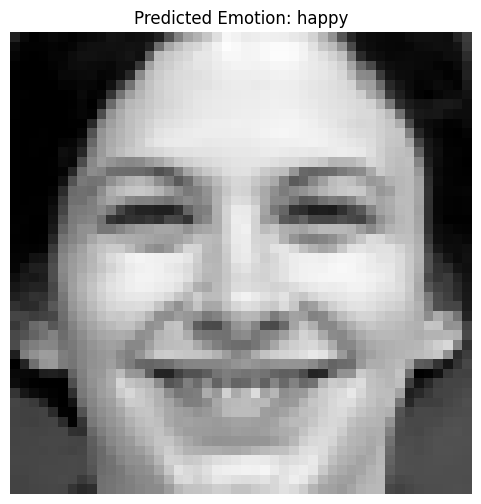

1/1 [==============================] - 0s 32ms/step


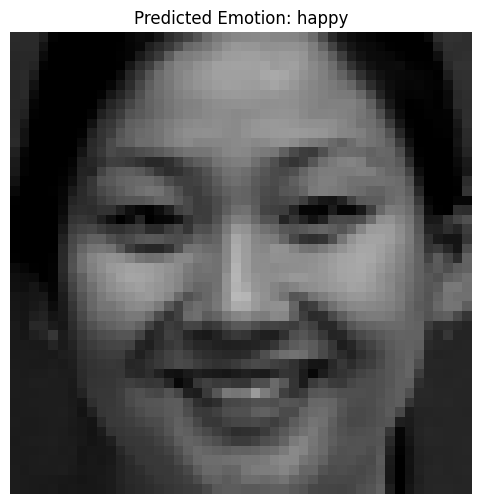

1/1 [==============================] - 0s 32ms/step


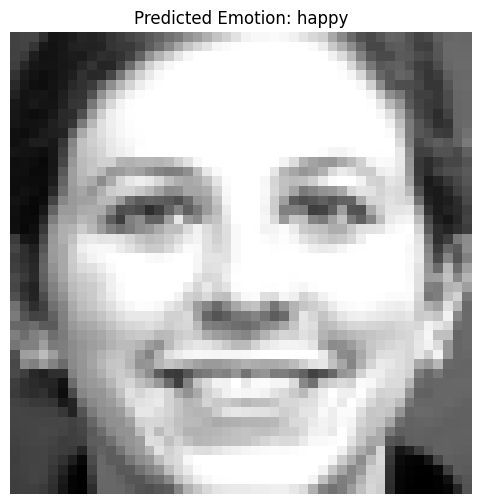

1/1 [==============================] - 0s 31ms/step


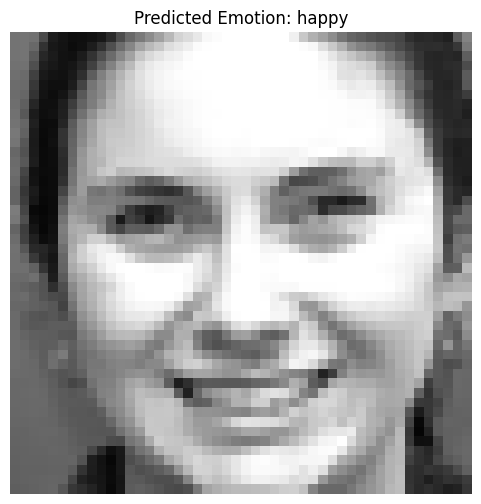

1/1 [==============================] - 0s 31ms/step


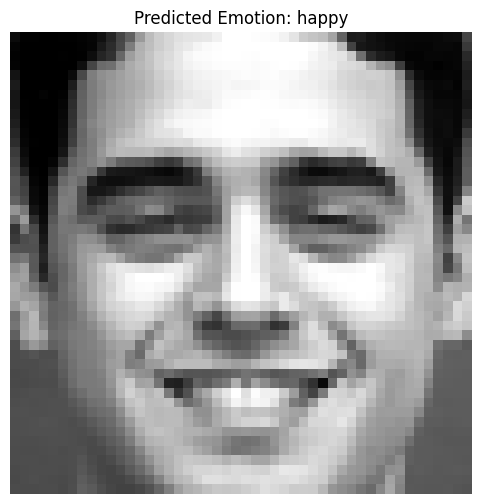

1/1 [==============================] - 0s 45ms/step


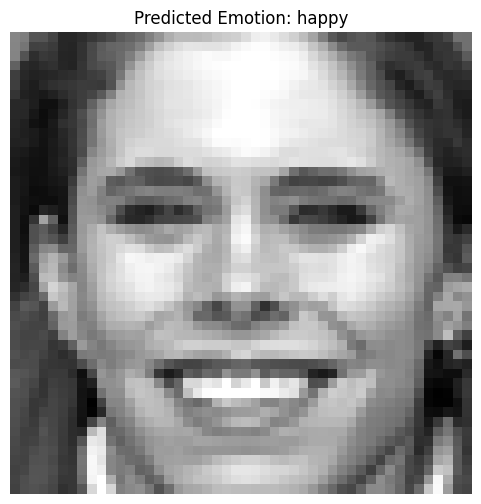

1/1 [==============================] - 0s 46ms/step


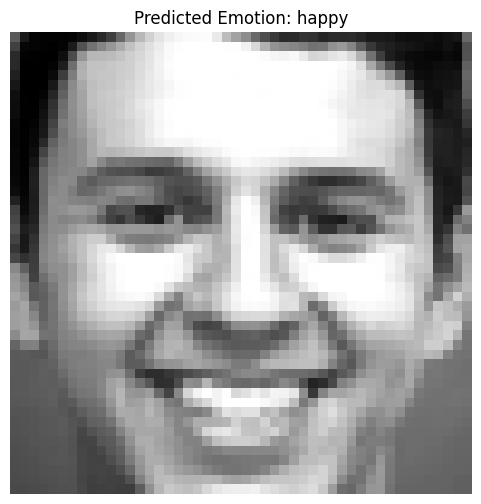

1/1 [==============================] - 0s 34ms/step


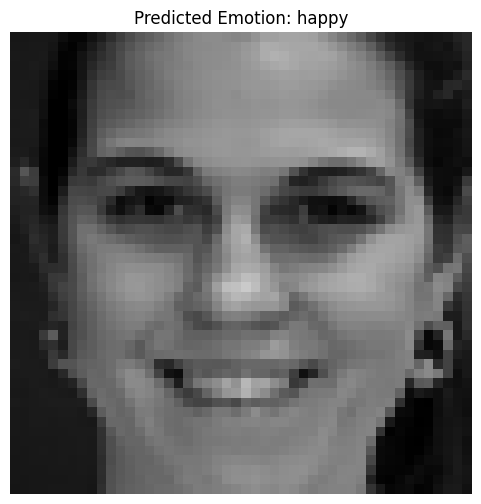

1/1 [==============================] - 0s 32ms/step


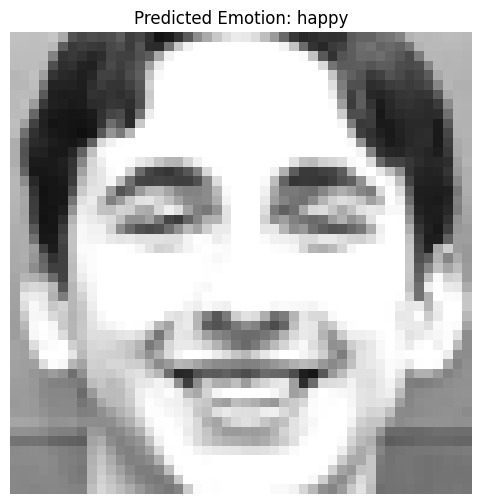

1/1 [==============================] - 0s 22ms/step


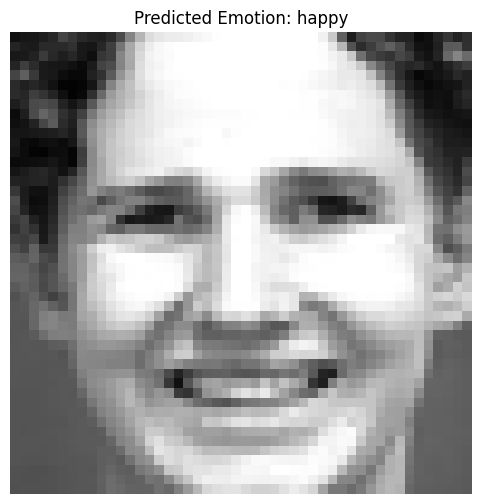

1/1 [==============================] - 0s 22ms/step


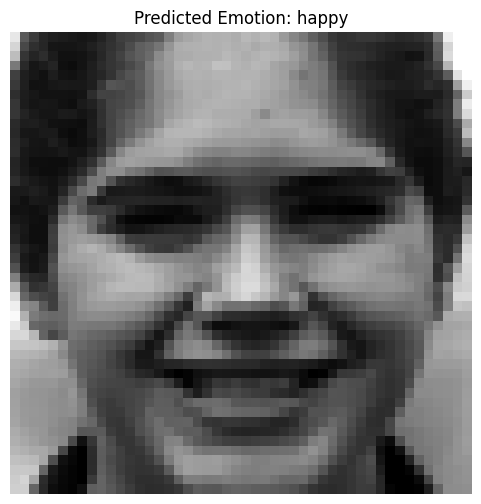

1/1 [==============================] - 0s 29ms/step


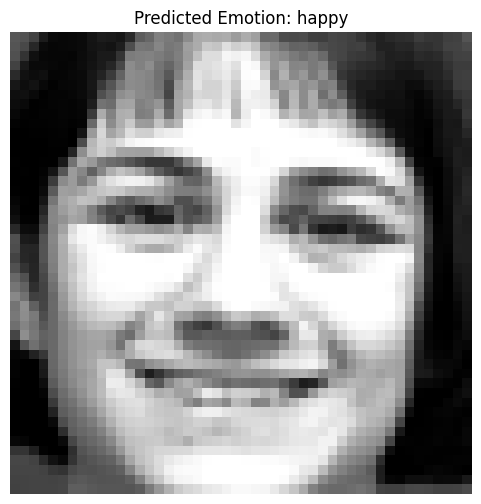

1/1 [==============================] - 0s 26ms/step


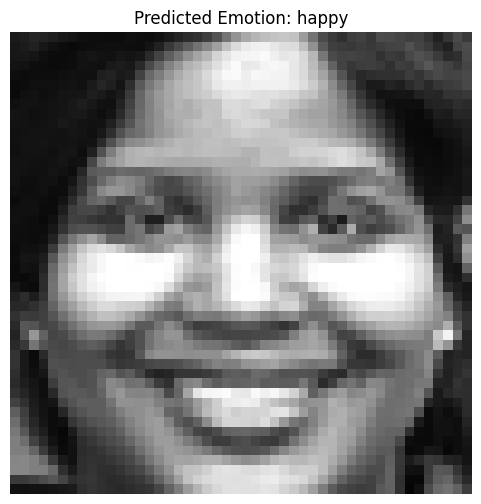

1/1 [==============================] - 0s 22ms/step


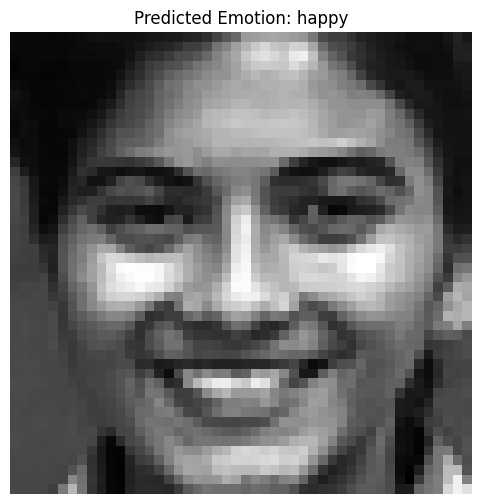

1/1 [==============================] - 0s 25ms/step


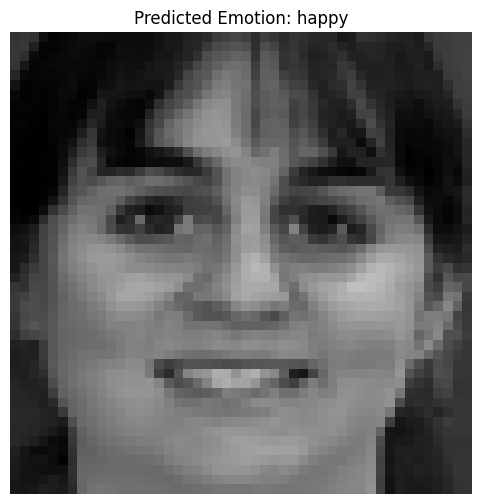

1/1 [==============================] - 0s 21ms/step


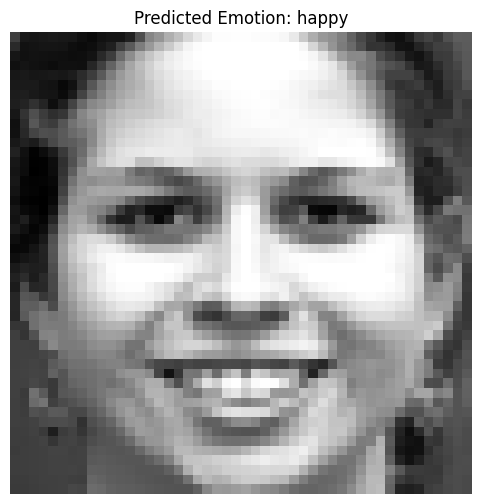

1/1 [==============================] - 0s 22ms/step


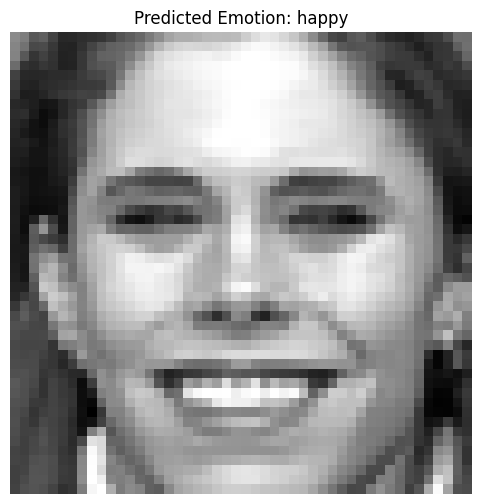

1/1 [==============================] - 0s 21ms/step


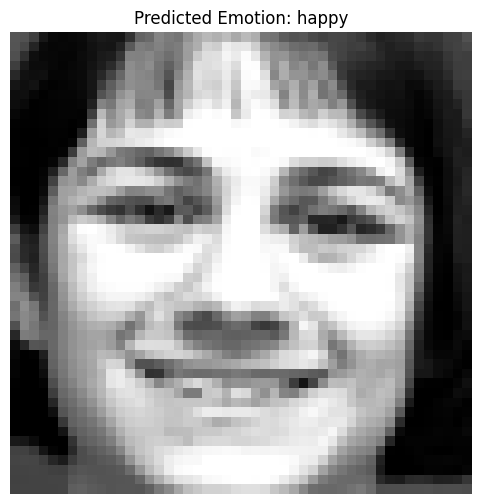

1/1 [==============================] - 0s 23ms/step


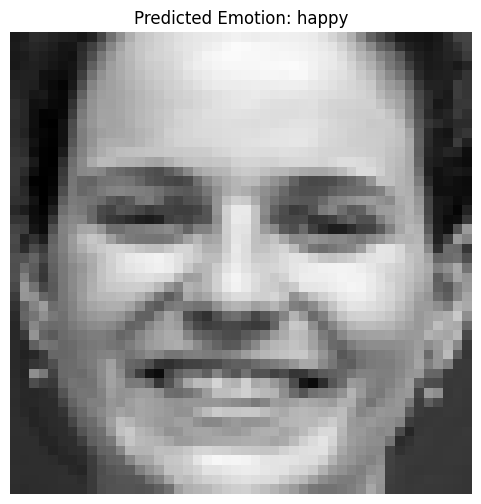

1/1 [==============================] - 0s 32ms/step


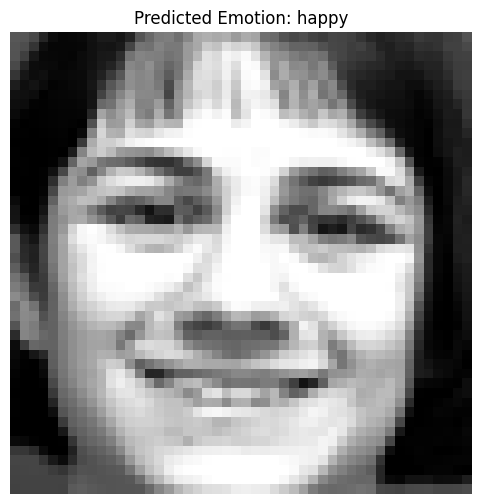

1/1 [==============================] - 0s 24ms/step


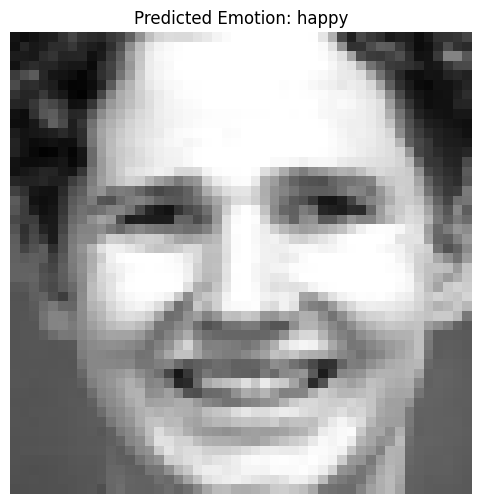

1/1 [==============================] - 0s 21ms/step


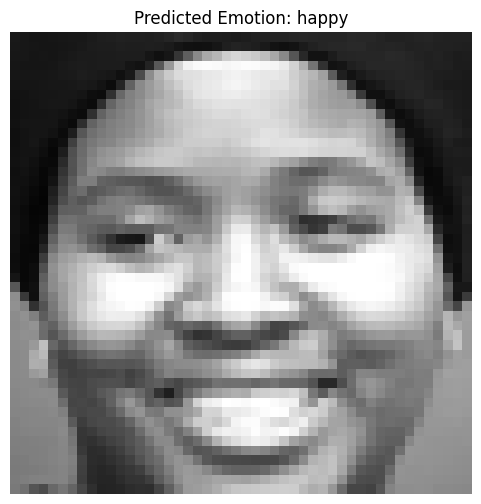

1/1 [==============================] - 0s 21ms/step


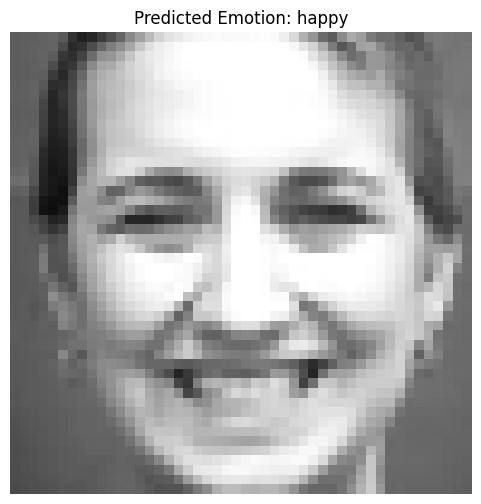

1/1 [==============================] - 0s 24ms/step


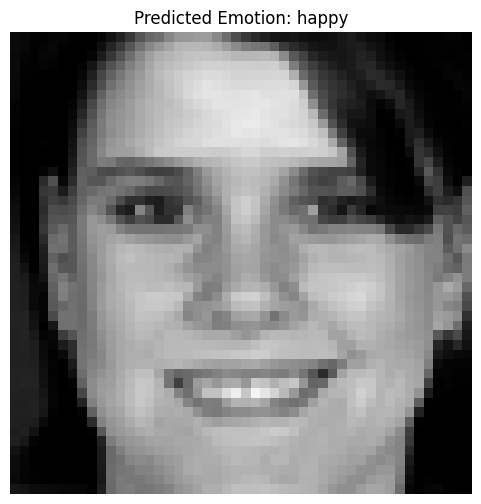

1/1 [==============================] - 0s 25ms/step


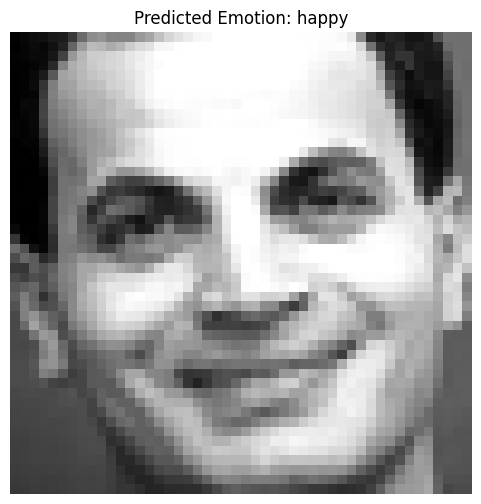

1/1 [==============================] - 0s 21ms/step


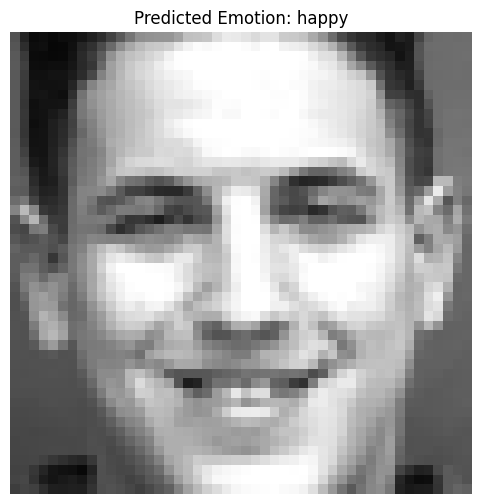

1/1 [==============================] - 0s 20ms/step


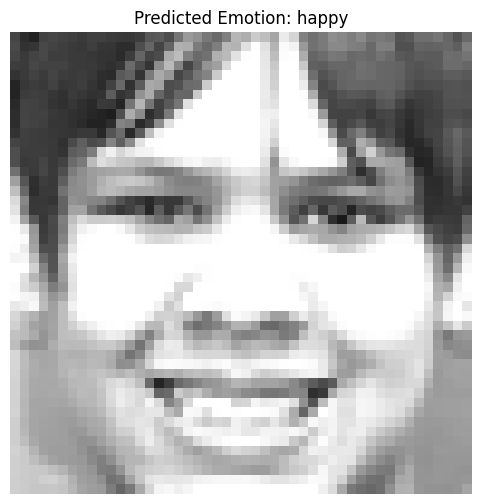

1/1 [==============================] - 0s 21ms/step


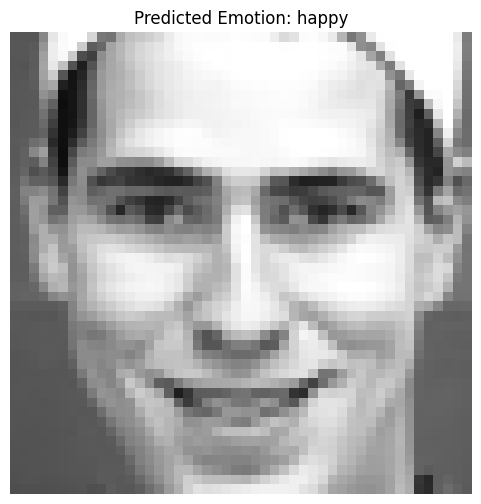

1/1 [==============================] - 0s 22ms/step


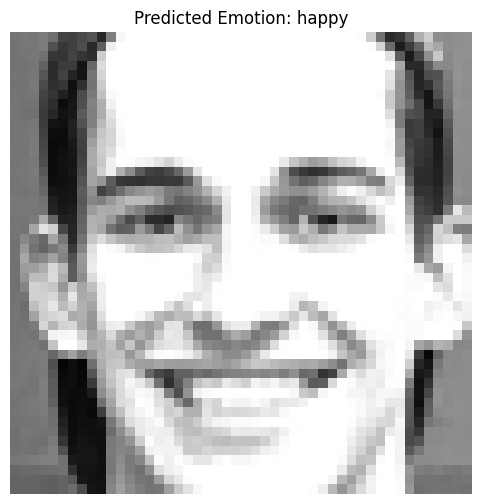

1/1 [==============================] - 0s 27ms/step


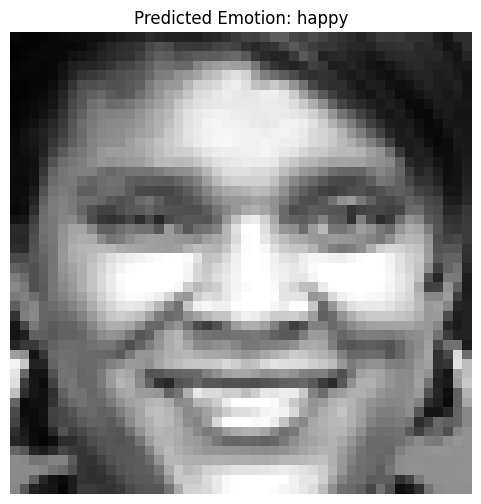

1/1 [==============================] - 0s 20ms/step


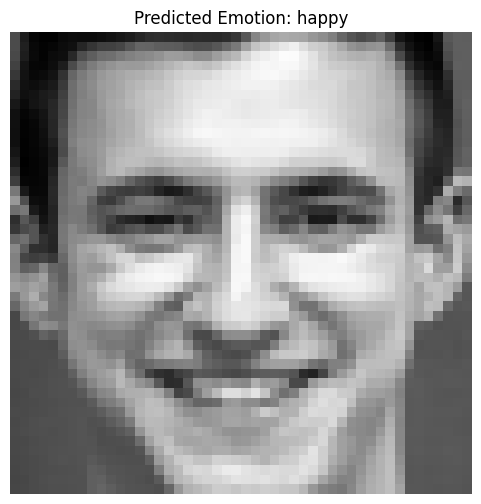

1/1 [==============================] - 0s 20ms/step


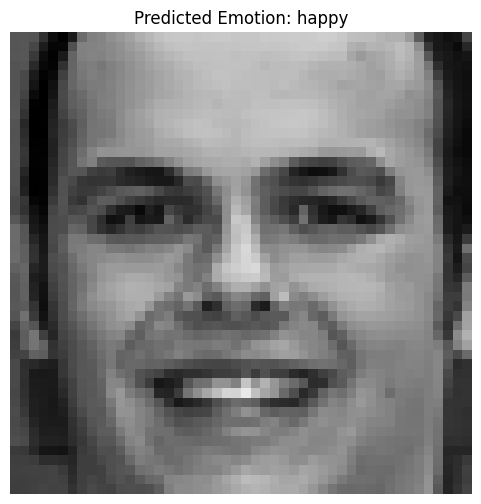

1/1 [==============================] - 0s 21ms/step


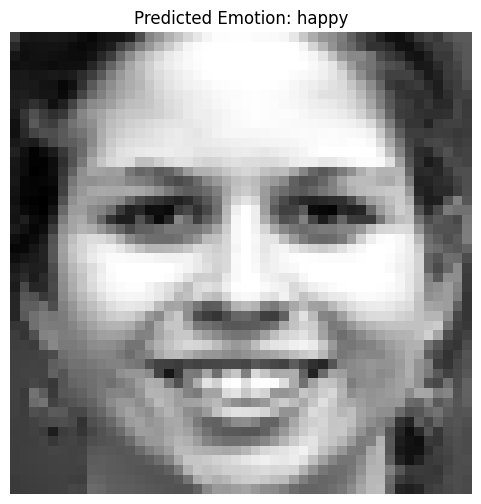

1/1 [==============================] - 0s 27ms/step


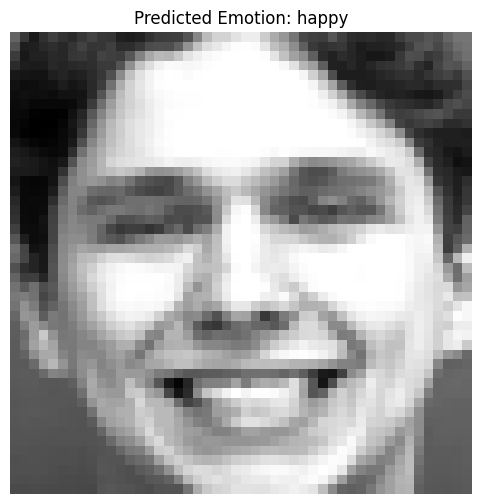

1/1 [==============================] - 0s 21ms/step


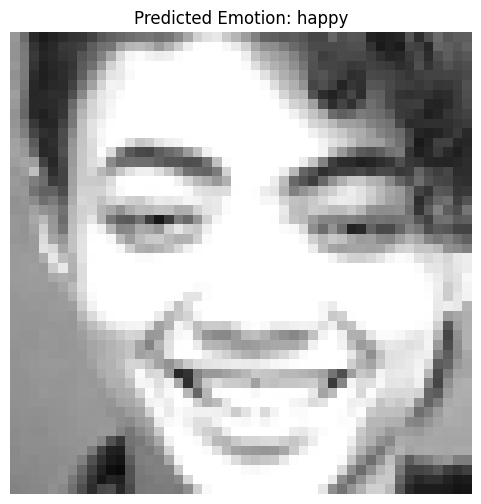

1/1 [==============================] - 0s 24ms/step


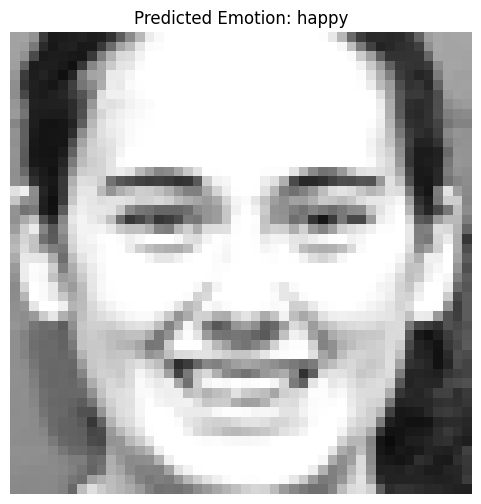

1/1 [==============================] - 0s 24ms/step


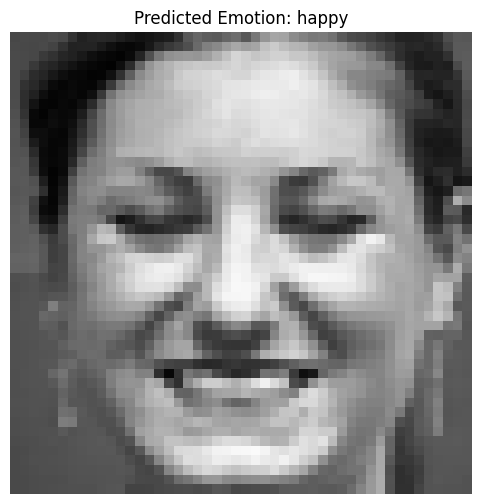

1/1 [==============================] - 0s 27ms/step


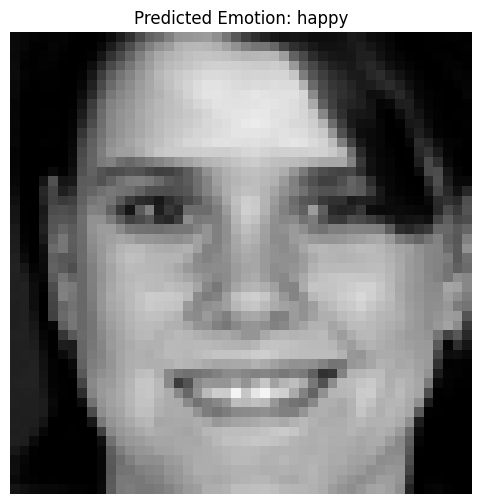

1/1 [==============================] - 0s 20ms/step


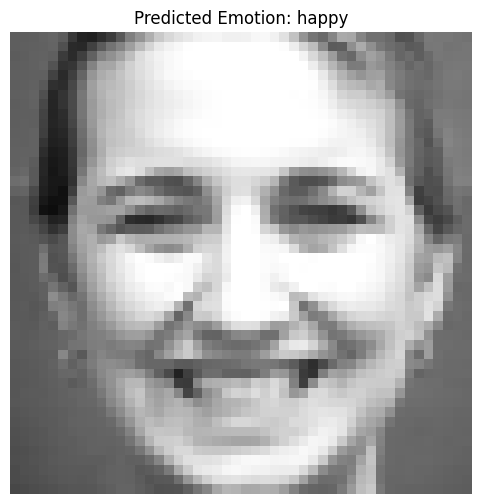

1/1 [==============================] - 0s 22ms/step


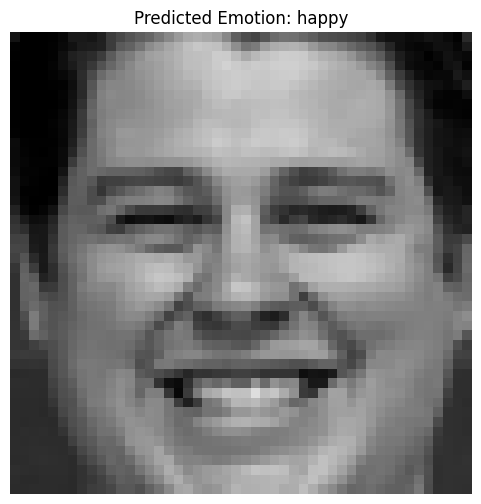

1/1 [==============================] - 0s 25ms/step


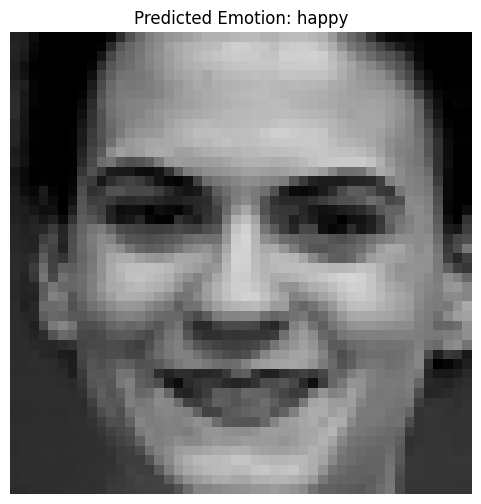

1/1 [==============================] - 0s 21ms/step


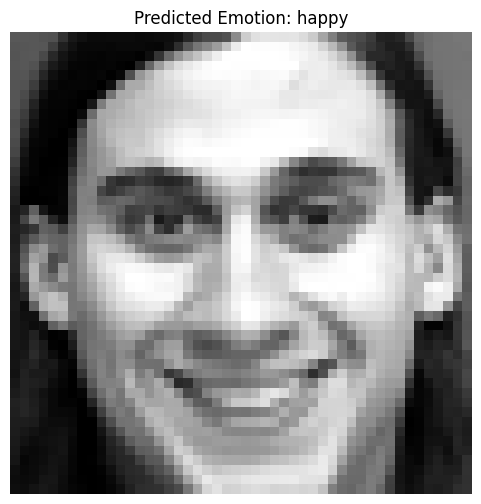

1/1 [==============================] - 0s 21ms/step


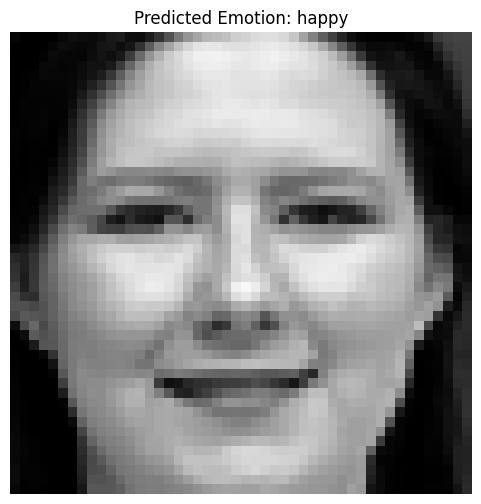

1/1 [==============================] - 0s 20ms/step


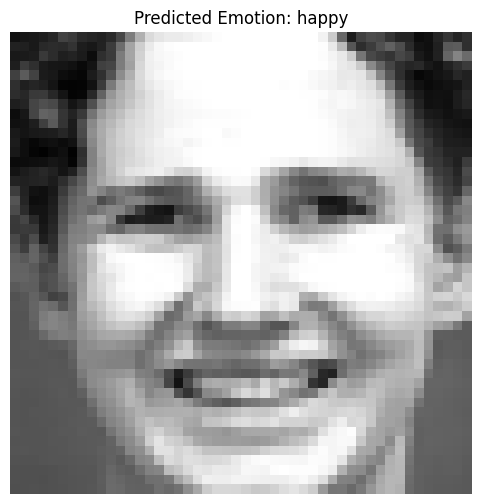

1/1 [==============================] - 0s 21ms/step


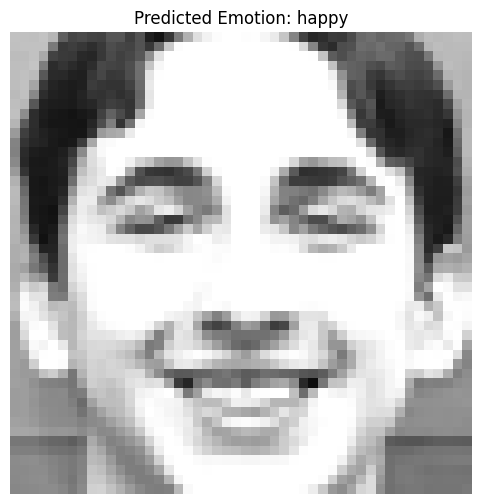

1/1 [==============================] - 0s 20ms/step


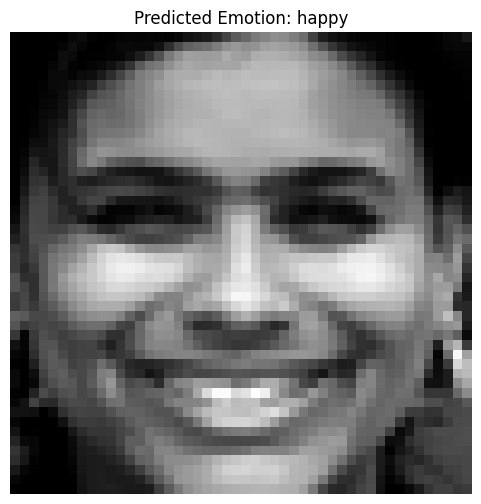

1/1 [==============================] - 0s 28ms/step


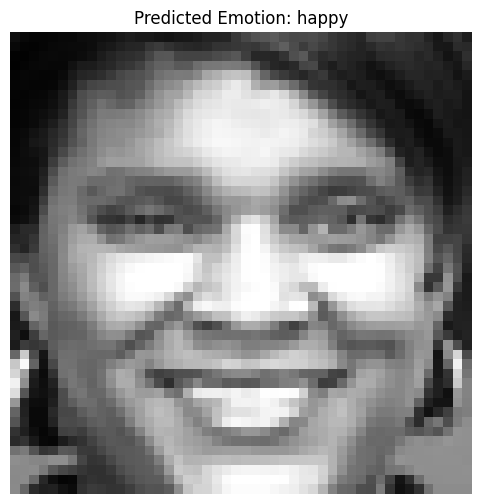

1/1 [==============================] - 0s 28ms/step


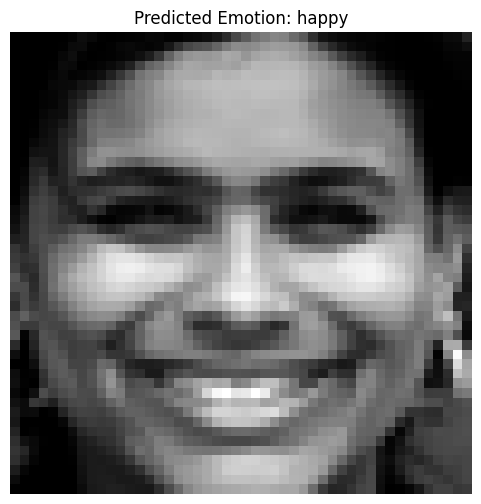

1/1 [==============================] - 0s 20ms/step


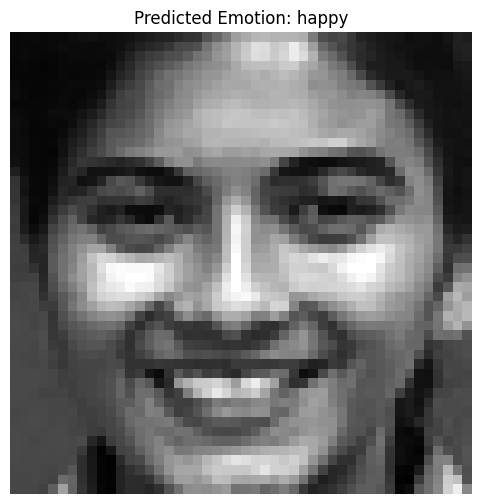

1/1 [==============================] - 0s 21ms/step


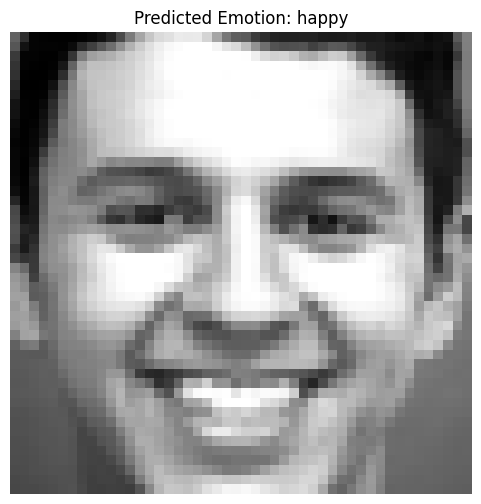

1/1 [==============================] - 0s 29ms/step


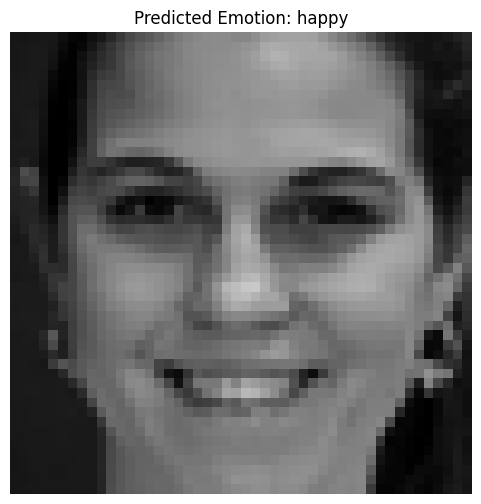

1/1 [==============================] - 0s 23ms/step


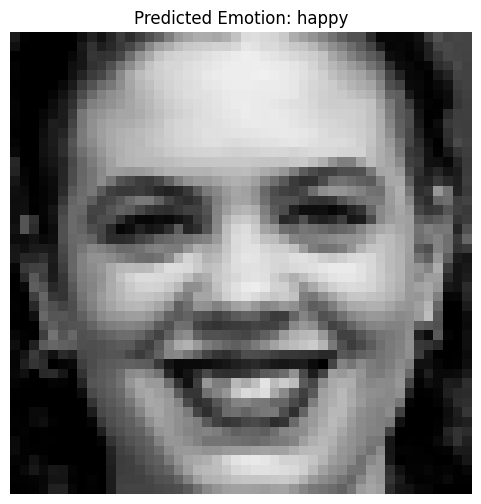

1/1 [==============================] - 0s 26ms/step


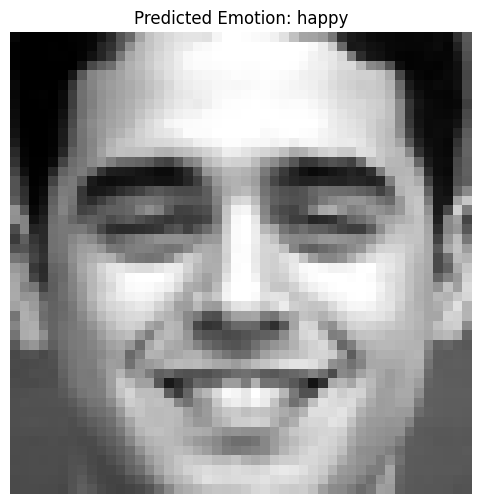

1/1 [==============================] - 0s 37ms/step


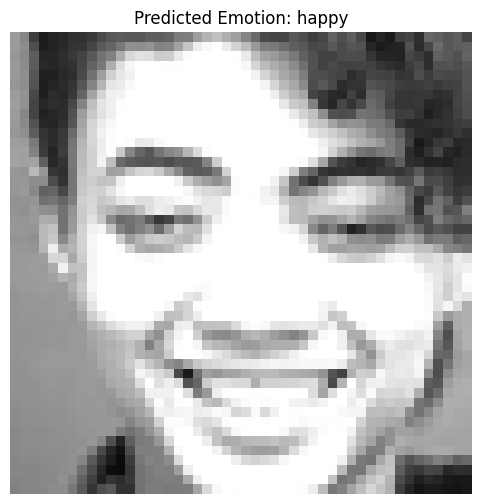

1/1 [==============================] - 0s 61ms/step


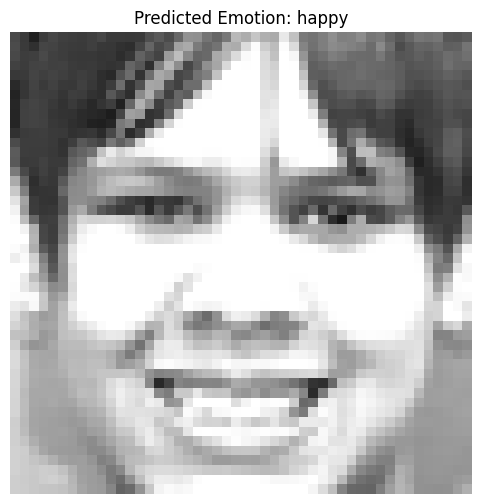

1/1 [==============================] - 0s 36ms/step


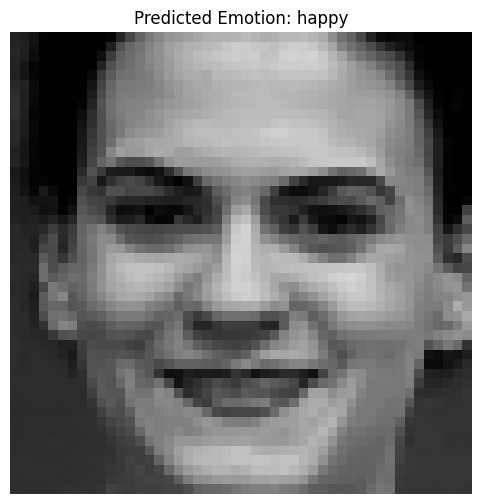

1/1 [==============================] - 0s 39ms/step


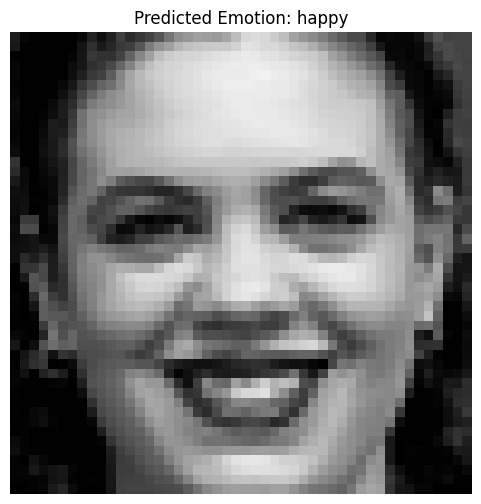

1/1 [==============================] - 0s 30ms/step


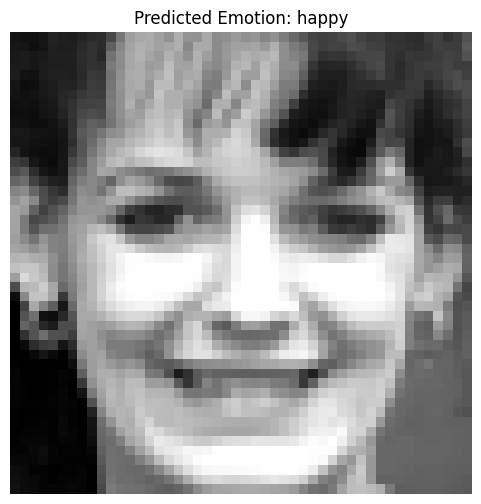

1/1 [==============================] - 0s 29ms/step


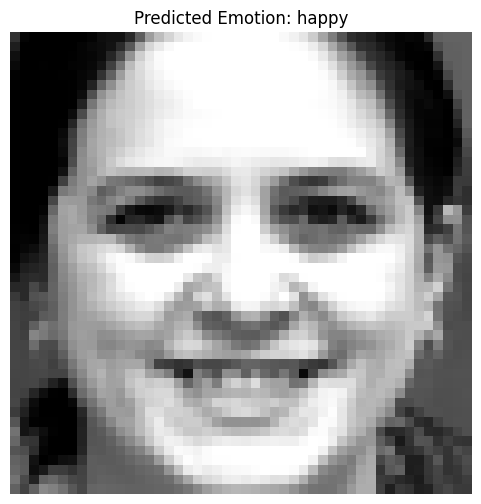

1/1 [==============================] - 0s 46ms/step


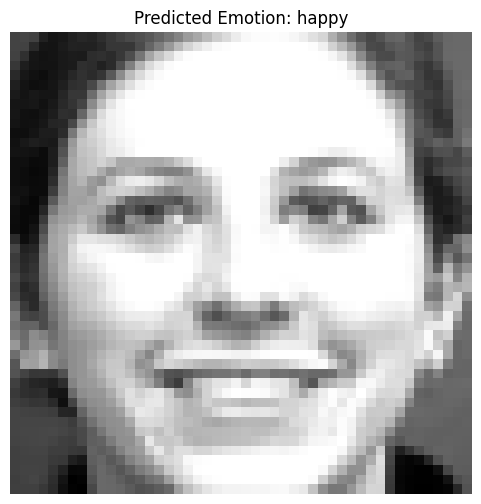

1/1 [==============================] - 0s 30ms/step


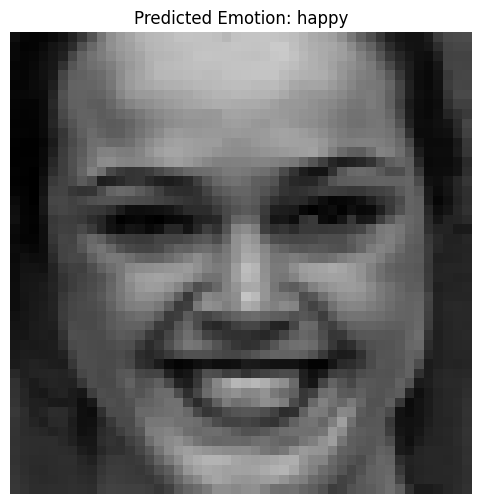

1/1 [==============================] - 0s 41ms/step


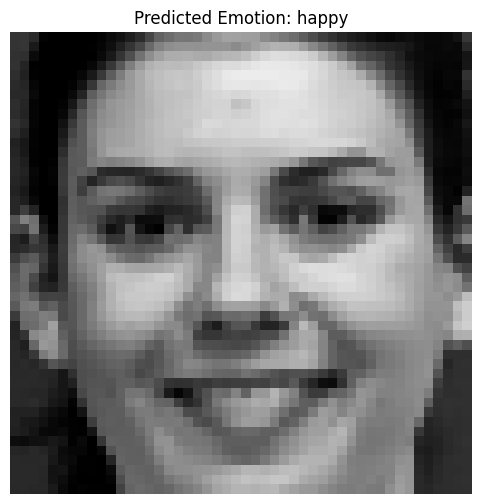

1/1 [==============================] - 0s 64ms/step


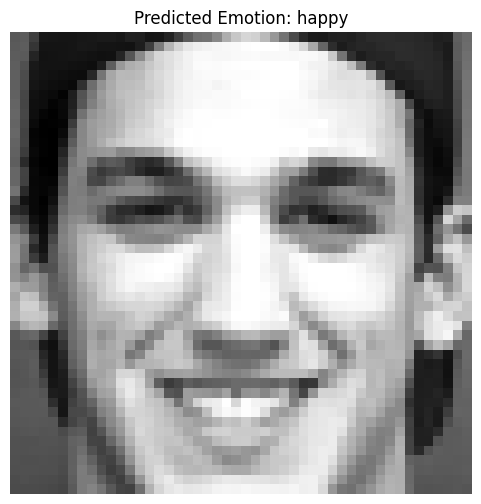

1/1 [==============================] - 0s 37ms/step


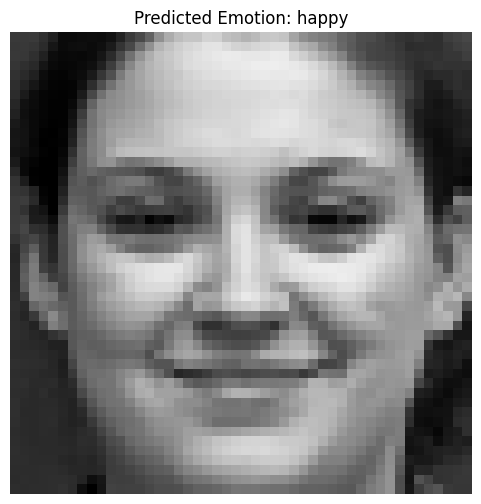

1/1 [==============================] - 0s 33ms/step


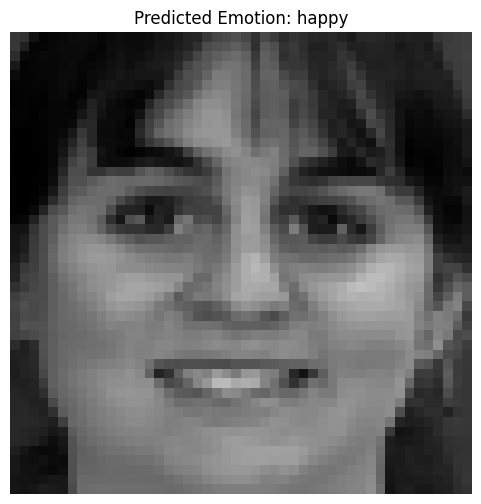

1/1 [==============================] - 0s 40ms/step


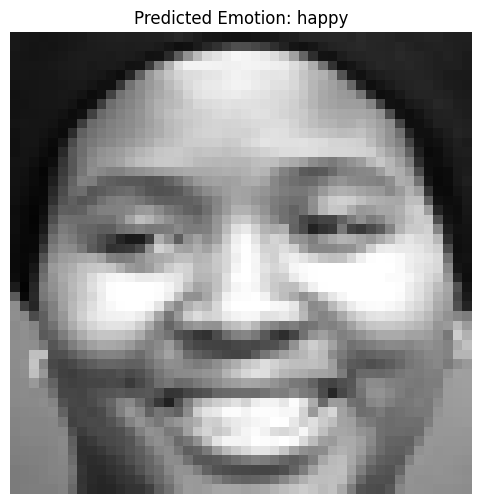

1/1 [==============================] - 0s 25ms/step


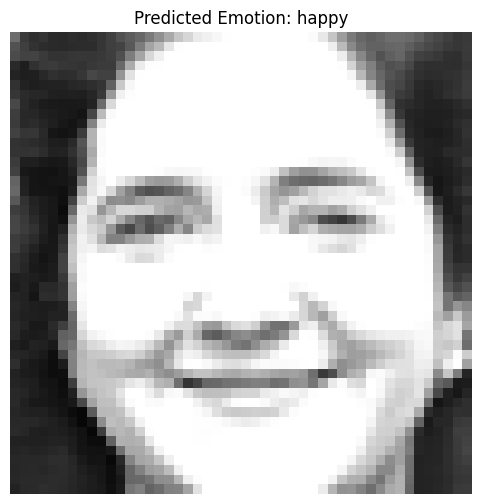

1/1 [==============================] - 0s 21ms/step


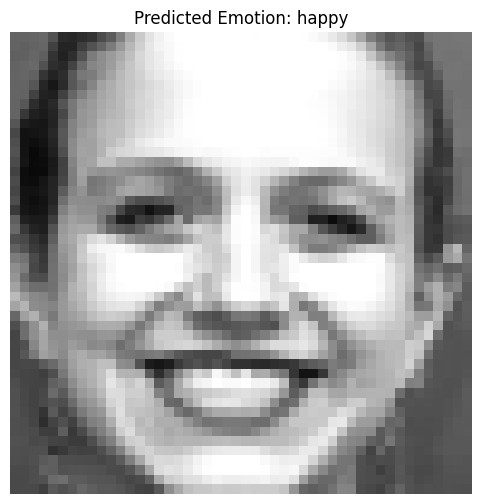

1/1 [==============================] - 0s 23ms/step


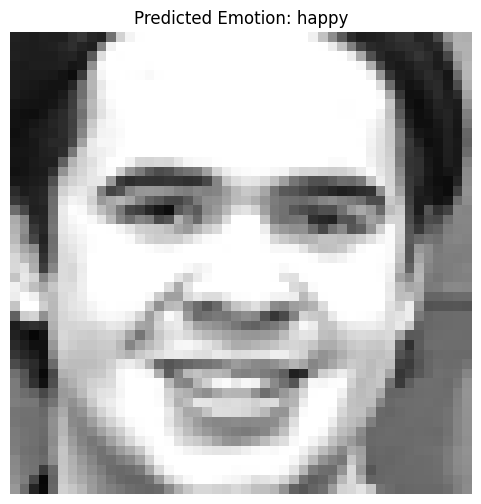

1/1 [==============================] - 0s 24ms/step


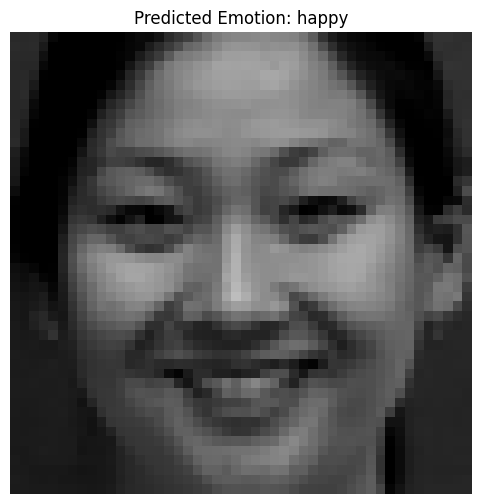

1/1 [==============================] - 0s 23ms/step


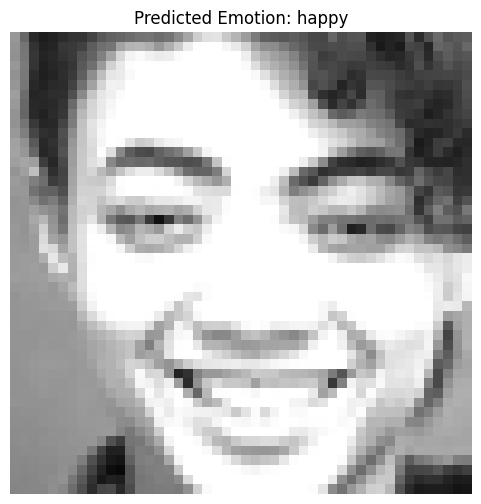

1/1 [==============================] - 0s 22ms/step


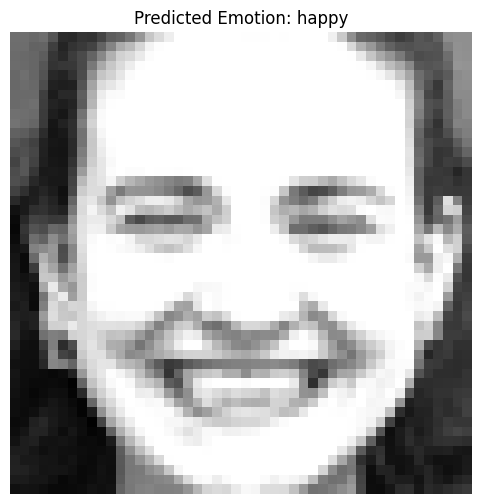

1/1 [==============================] - 0s 22ms/step


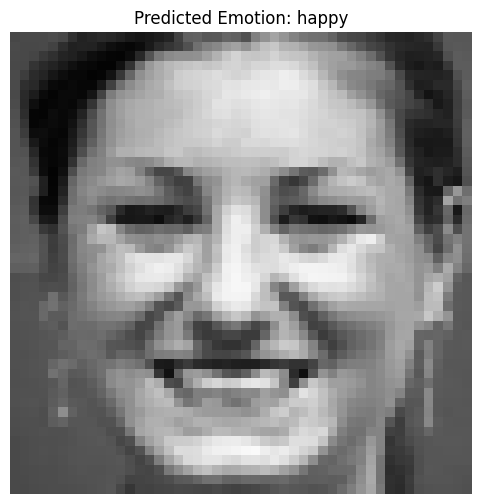

1/1 [==============================] - 0s 21ms/step


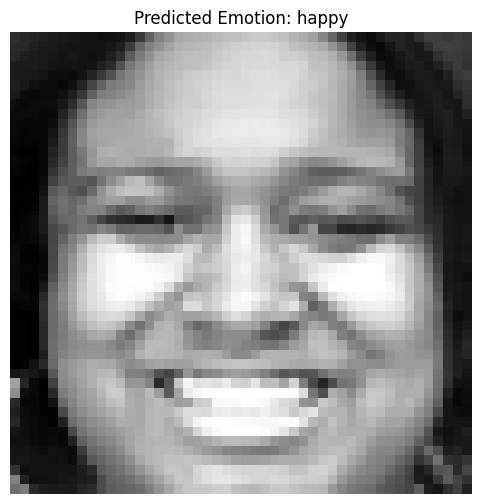

1/1 [==============================] - 0s 26ms/step


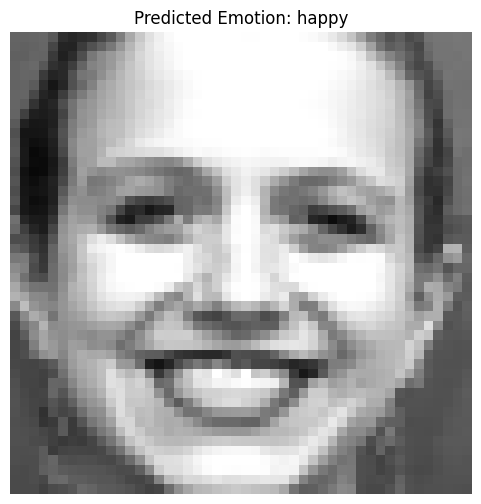

1/1 [==============================] - 0s 23ms/step


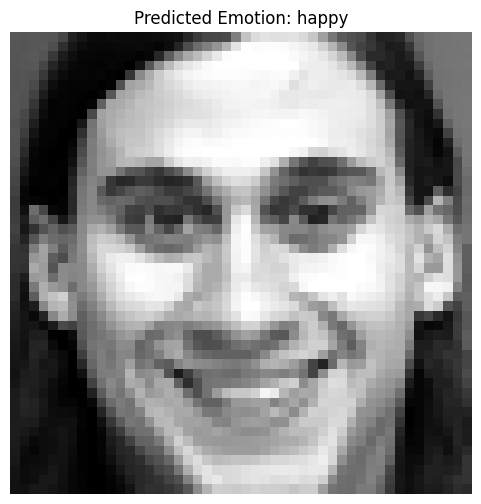

1/1 [==============================] - 0s 32ms/step


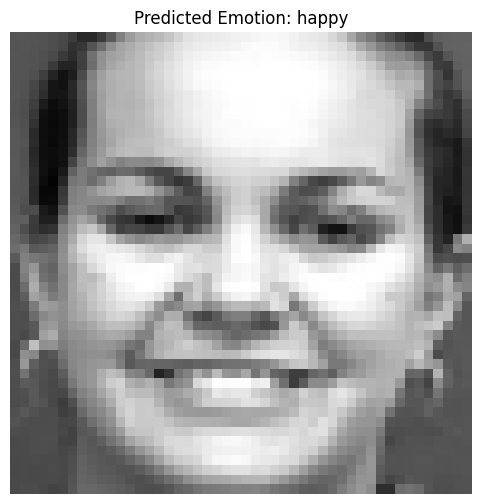

1/1 [==============================] - 0s 22ms/step


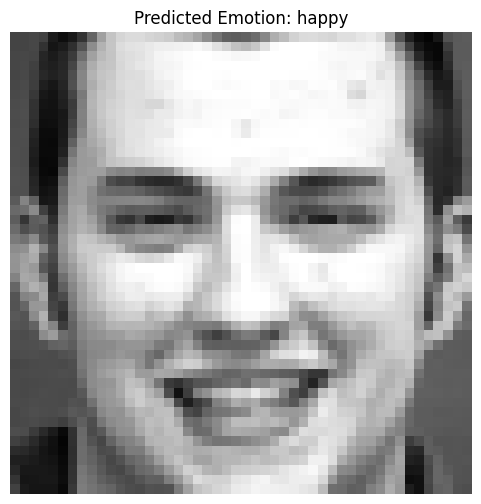

1/1 [==============================] - 0s 27ms/step


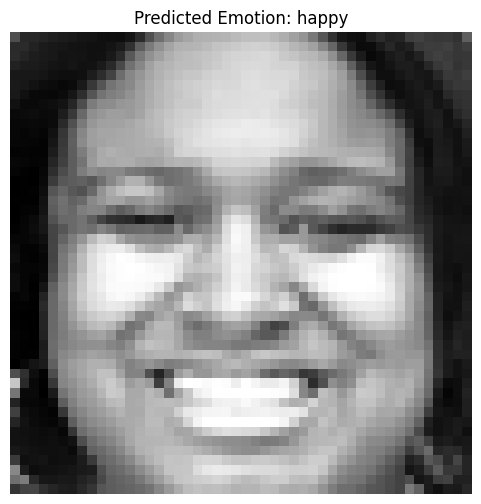

1/1 [==============================] - 0s 24ms/step


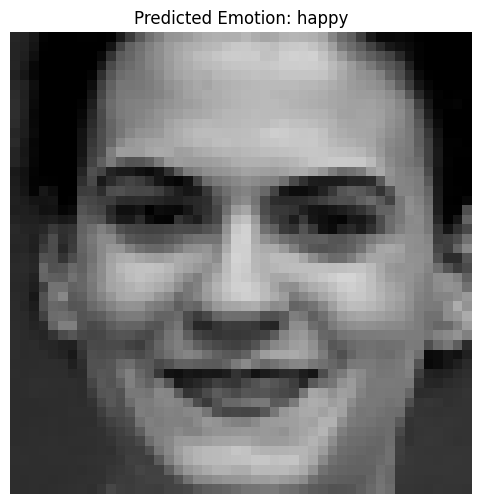

1/1 [==============================] - 0s 23ms/step


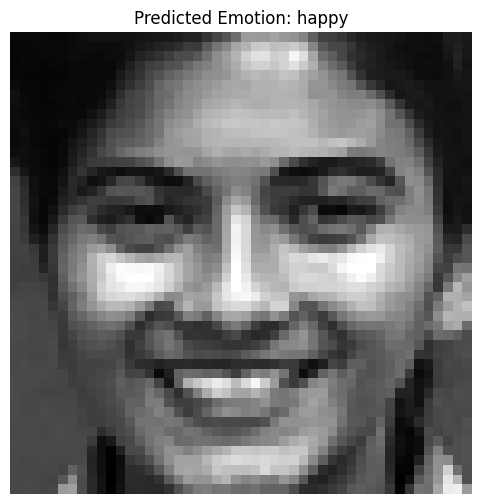

1/1 [==============================] - 0s 21ms/step


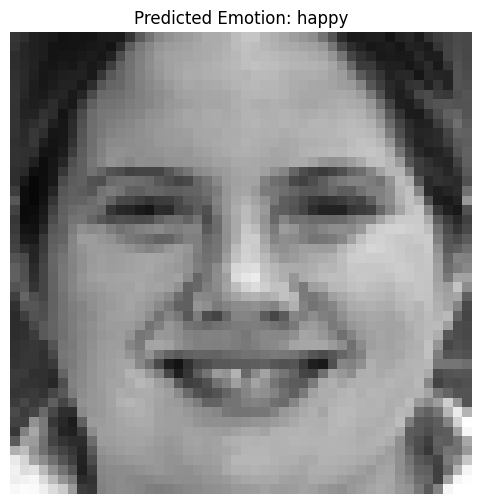

1/1 [==============================] - 0s 23ms/step


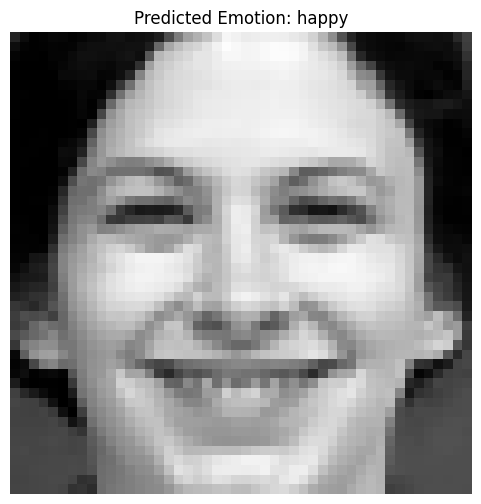

1/1 [==============================] - 0s 29ms/step


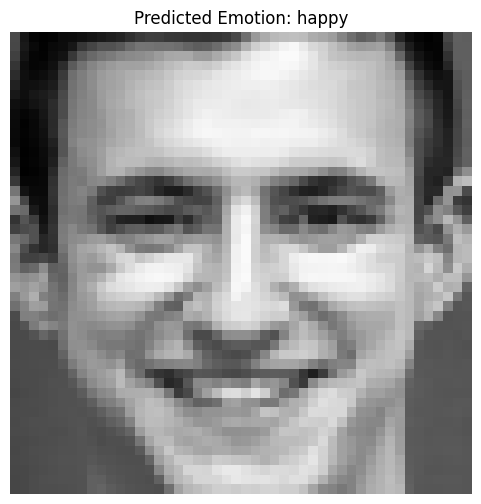

1/1 [==============================] - 0s 31ms/step


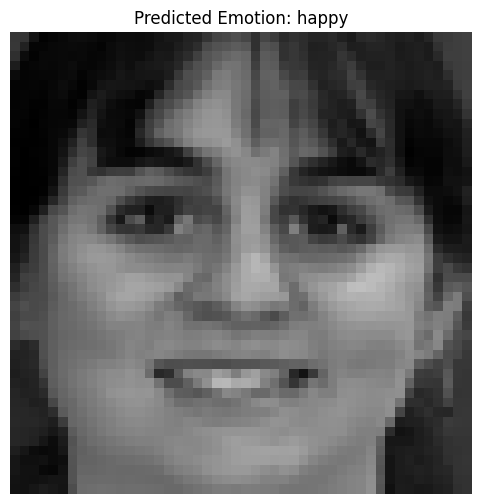

1/1 [==============================] - 0s 26ms/step


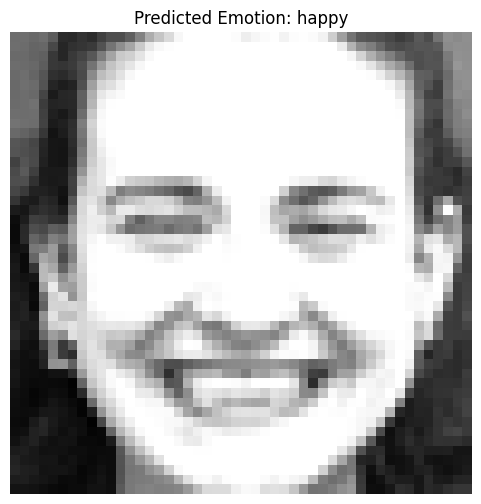

1/1 [==============================] - 0s 27ms/step


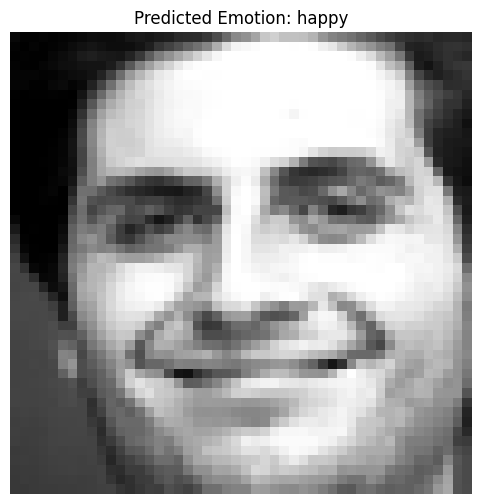

1/1 [==============================] - 0s 24ms/step


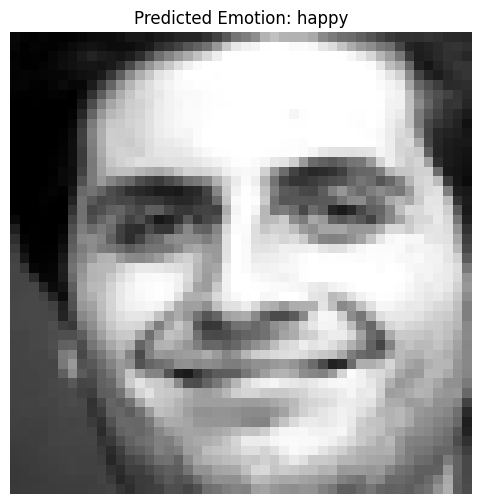

1/1 [==============================] - 0s 24ms/step


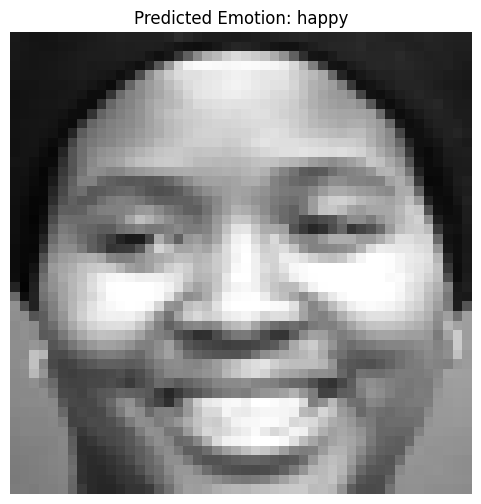

1/1 [==============================] - 0s 29ms/step


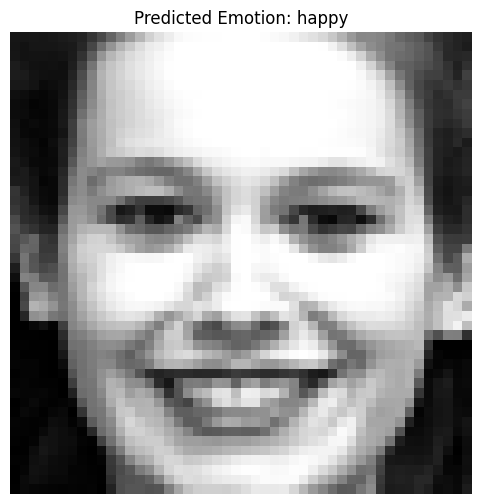

1/1 [==============================] - 0s 25ms/step


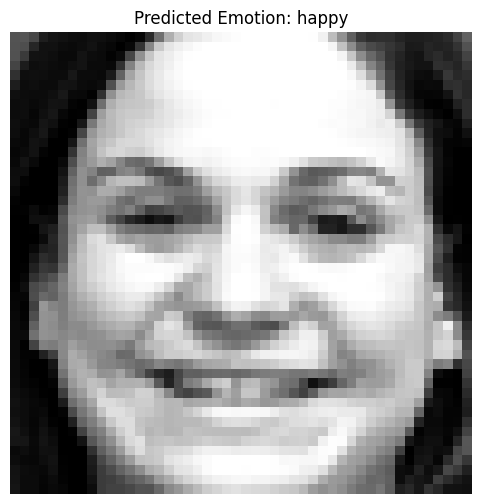

1/1 [==============================] - 0s 28ms/step


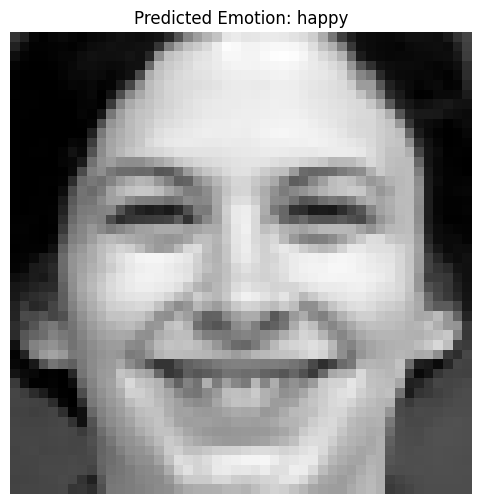

1/1 [==============================] - 0s 23ms/step


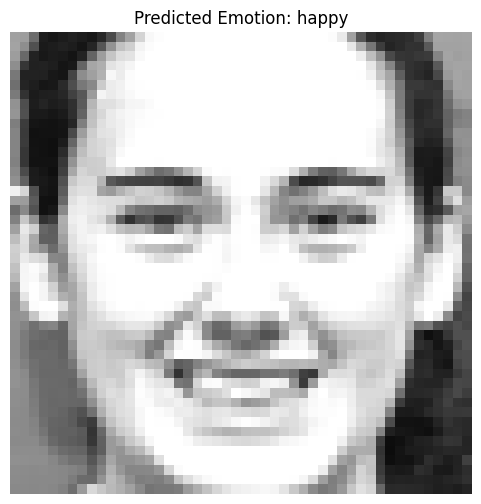

1/1 [==============================] - 0s 24ms/step


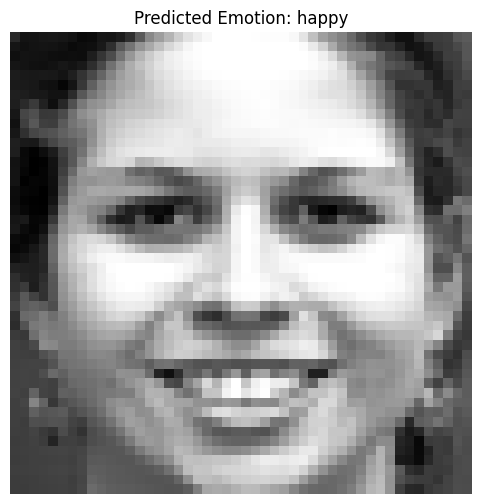

1/1 [==============================] - 0s 26ms/step


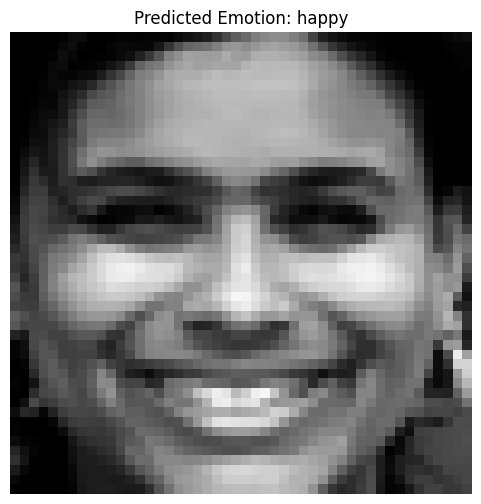

1/1 [==============================] - 0s 32ms/step


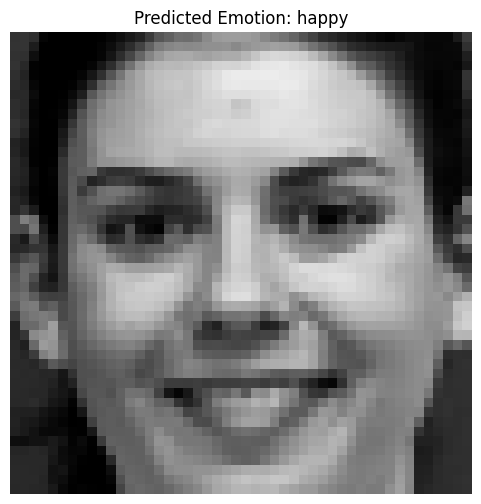

1/1 [==============================] - 0s 22ms/step


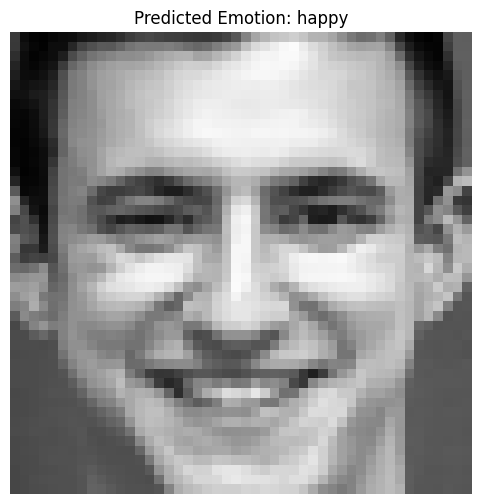

1/1 [==============================] - 0s 24ms/step


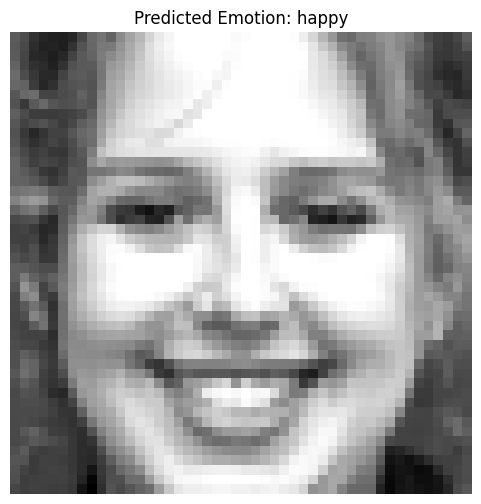

1/1 [==============================] - 0s 31ms/step


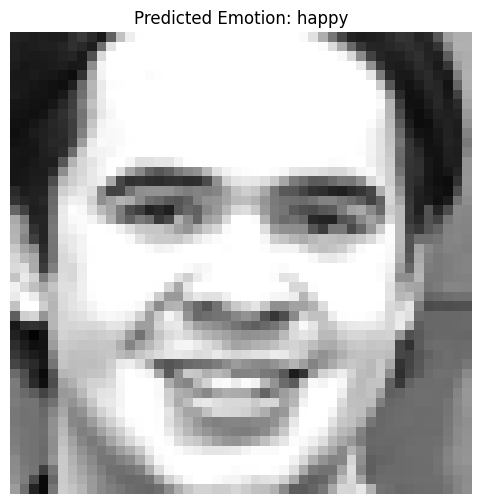

1/1 [==============================] - 0s 25ms/step


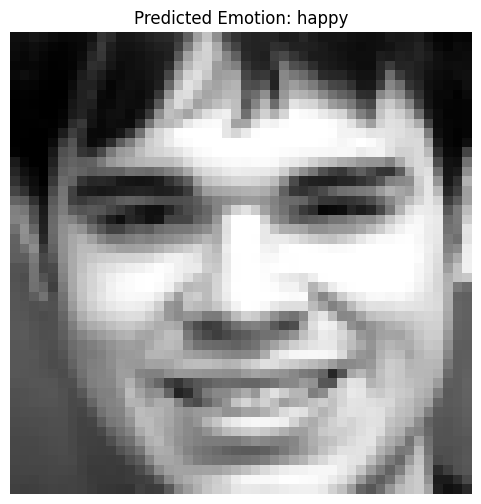

In [12]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load your trained CNN model and SVM classifier
# ...

# Define your classes
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Path to the folder containing images for prediction
images_folder = '/content/extracted/happy'  # Replace with the path to the folder containing your images

# Loop through images in the folder
for image_file in os.listdir(images_folder):
    image_path = os.path.join(images_folder, image_file)
    img_to_predict = tf.keras.preprocessing.image.load_img(image_path, target_size=(48, 48))
    img_array_to_predict = tf.keras.preprocessing.image.img_to_array(img_to_predict)

    # Use your CNN model to extract features from the image
    features_to_predict = model.predict(np.expand_dims(img_array_to_predict, axis=0))

    # Flatten the extracted features
    features_to_predict_flatten = features_to_predict.reshape(1, -1)

    # Use the SVM classifier to predict the emotion class
    predicted_class_index = svm_classifier.predict(features_to_predict_flatten)[0]
    predicted_class = classes[predicted_class_index]

    # Display the image with the predicted emotion
    plt.figure(figsize=(6, 6))
    plt.imshow(img_to_predict)
    plt.title(f"Predicted Emotion: {predicted_class}")
    plt.axis('off')
    plt.show()

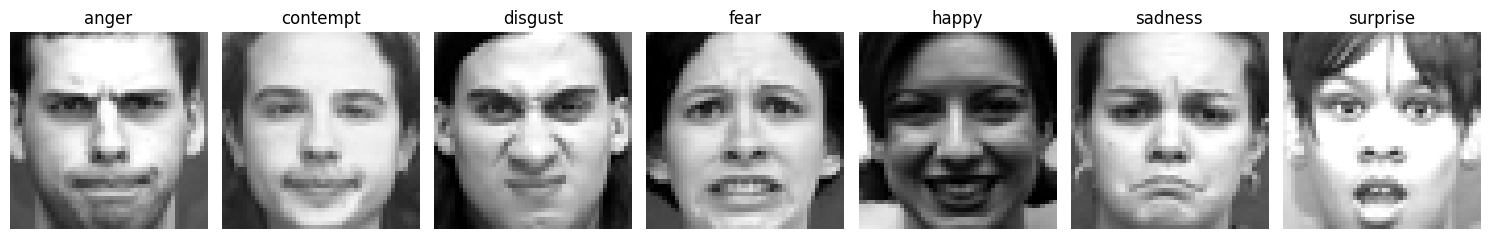

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Define your classes
classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Load and preprocess a single image for visualization
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(48, 48))
    img_array = img_to_array(img)
    return img_array

# Path to the directory containing images for each class
base_dir = '/content/extracted'

# Create a new figure and specify the number of rows and columns for subplots
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

# Iterate through each class and display an image
for idx, emotion_class in enumerate(classes):
    class_path = os.path.join(base_dir, emotion_class)
    image_files = os.listdir(class_path)
    image_path = os.path.join(class_path, image_files[0])  # Take the first image in the class folder
    image_array = preprocess_image(image_path)

    # Display the image
    axes[idx].imshow(image_array.astype(np.uint8))
    axes[idx].set_title(emotion_class)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
